In [1]:
from GvaDataset import GvaDataset
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms 


transform = transforms.Compose([
    transforms.Resize((1024, 512)),
    transforms.RandomHorizontalFlip(p=0.5)
])

images_path = "/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/data/_Original"
labels_path = "/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/data/labels"
dataset = GvaDataset(images_path, labels_path, transform=transform)

total_size = len(dataset)
train_size = int(total_size * 0.8)  # 80% for training
test_size = total_size - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [2]:
import torch
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm


class Experiment:
    def __init__(self, model, criterion, optimizer, device='cpu', starting_epoch=0):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.starting_epoch = starting_epoch

        self.loss_history = []
        self.validation_loss_history = []
        self.epoch_loss_history = []

    def train(self, train_loader, validation_loader, epochs=10):
        N = len(train_loader)
        for epoch in range(1, epochs + 1):
            self.model.train()
            epoch_loss = 0
            with tqdm(enumerate(train_loader), 
                      total=N, 
                      desc=f'Epoch {self.starting_epoch + epoch}/{self.starting_epoch + epochs}', 
                      unit='batch') as pbar:
                for i, data in pbar:
                    images, labels, _ = data

                    images = images.to(self.device)
                    labels = labels.to(self.device)

                    self.optimizer.zero_grad()

                    pred = self.model(images)

                    pred = torch.squeeze(pred)
                    labels = torch.squeeze(labels)
                
                    loss = self.criterion(pred, labels)
                    loss.backward()
                    self.optimizer.step()

                    epoch_loss += loss.item()
                    pbar.set_postfix(loss = loss.item(), avg_loss=epoch_loss / (i + 1))
                    self.loss_history.append(loss.item())

            self.model.eval()
            with torch.no_grad():
                epoch_val_loss = 0
                for images, labels, _ in validation_loader:
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    pred = self.model(images)
                    labels = torch.squeeze(labels)
                    pred = torch.squeeze(pred)
                    val_loss = self.criterion(pred, labels)
                    epoch_val_loss += val_loss.item()

            print(f'{self.starting_epoch +  epoch}/{self.starting_epoch + epochs} train loss: {epoch_loss / N}  val loss: {epoch_val_loss / len(validation_loader)}')
            self.epoch_loss_history.append(epoch_loss / N)
            self.validation_loss_history.append(epoch_val_loss / len(validation_loader))
            epoch_loss = 0
        
        print("Training Complete")

    def save_weights(self, file_name):
        assert file_name.ends_with(".pth")

        torch.save(self.model.state_dict(), file_name)

    def save_loss(self, file_name):
        assert file_name.ends_with(".pkl")

        loss_dict = dict(loss=self.loss, epoch_loss=self.epoch_loss)

        with open(file_name, 'wb') as f:
            pickle.dump(loss_dict, f)

    def plot_loss(self):
        plt.plot(self.epoch_loss_history, color='blue', label='Training Loss')
        plt.plot(self.validation_loss_history, color='green', label='Validation Loss')
        plt.title("Training Loss")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel(self.criterion.__name__)

    def load_model(self, file_name):
        state_dict = torch.load(file_name)
        self.model.load_state_dict(state_dict)


In [3]:
from models.unet import UNet
# from experiment import Experiment
from losses import dice_loss
import torch.optim as optim
import torch.nn as nn
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(in_channels=3, out_channels=2).to(device)
optimizer = optim.Adam(model.parameters())
criterion = dice_loss
experiment = Experiment(model, criterion, optimizer, device)

In [4]:
experiment.train(train_loader=train_loader, validation_loader=test_loader, epochs=500)

Epoch 1/500: 100%|█| 6/6 [00:06<00:00,  1.03s/batch, avg_loss=0.918, loss=0.756]


1/500 train loss: 0.918261706829071  val loss: 0.8809894025325775


Epoch 2/500: 100%|█| 6/6 [00:05<00:00,  1.04batch/s, avg_loss=0.894, loss=0.805]


2/500 train loss: 0.8936370114485422  val loss: 0.8804180026054382


Epoch 3/500: 100%|█| 6/6 [00:05<00:00,  1.05batch/s, avg_loss=0.886, loss=0.958]


3/500 train loss: 0.8863076965014139  val loss: 0.9023499389489492


Epoch 4/500: 100%|█| 6/6 [00:05<00:00,  1.08batch/s, avg_loss=0.874, loss=0.868]


4/500 train loss: 0.8736850917339325  val loss: 0.8614081641038259


Epoch 5/500: 100%|█| 6/6 [00:05<00:00,  1.07batch/s, avg_loss=0.867, loss=0.948]


5/500 train loss: 0.8672579626242319  val loss: 0.871765673160553


Epoch 6/500: 100%|█| 6/6 [00:05<00:00,  1.10batch/s, avg_loss=0.864, loss=0.917]


6/500 train loss: 0.8644992411136627  val loss: 0.7968245446681976


Epoch 7/500: 100%|█| 6/6 [00:04<00:00,  1.21batch/s, avg_loss=0.863, loss=0.914]


7/500 train loss: 0.862754613161087  val loss: 0.8500765164693197


Epoch 8/500: 100%|█| 6/6 [00:04<00:00,  1.20batch/s, avg_loss=0.875, loss=0.936]


8/500 train loss: 0.8747458954652151  val loss: 0.8664193352063497


Epoch 9/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.854, loss=0.885]


9/500 train loss: 0.8544085423151652  val loss: 0.8951020737489065


Epoch 10/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.846, loss=0.905


10/500 train loss: 0.8457690874735514  val loss: 0.9121994574864706


Epoch 11/500: 100%|█| 6/6 [00:05<00:00,  1.15batch/s, avg_loss=0.826, loss=0.863


11/500 train loss: 0.8262174924214681  val loss: 0.8792105317115784


Epoch 12/500: 100%|█| 6/6 [00:05<00:00,  1.06batch/s, avg_loss=0.813, loss=0.875


12/500 train loss: 0.8125691612561544  val loss: 0.879459023475647


Epoch 13/500: 100%|█| 6/6 [00:05<00:00,  1.20batch/s, avg_loss=0.84, loss=0.916]


13/500 train loss: 0.8404455681641897  val loss: 0.8537522355715433


Epoch 14/500: 100%|█| 6/6 [00:04<00:00,  1.20batch/s, avg_loss=0.808, loss=0.704


14/500 train loss: 0.8080338438351949  val loss: 0.855041116476059


Epoch 15/500: 100%|█| 6/6 [00:05<00:00,  1.15batch/s, avg_loss=0.809, loss=0.912


15/500 train loss: 0.8091187278429667  val loss: 0.8596944014231364


Epoch 16/500: 100%|█| 6/6 [00:05<00:00,  1.08batch/s, avg_loss=0.788, loss=0.598


16/500 train loss: 0.7879137098789215  val loss: 0.8460999627908071


Epoch 17/500: 100%|█| 6/6 [00:05<00:00,  1.15batch/s, avg_loss=0.797, loss=0.903


17/500 train loss: 0.7966066499551138  val loss: 0.9138550162315369


Epoch 18/500: 100%|█| 6/6 [00:05<00:00,  1.03batch/s, avg_loss=0.795, loss=0.939


18/500 train loss: 0.7954294681549072  val loss: 0.8645492891470591


Epoch 19/500: 100%|█| 6/6 [00:05<00:00,  1.10batch/s, avg_loss=0.785, loss=0.812


19/500 train loss: 0.7849618991216024  val loss: 0.8682257930437723


Epoch 20/500: 100%|█| 6/6 [00:05<00:00,  1.14batch/s, avg_loss=0.817, loss=0.791


20/500 train loss: 0.8170037964979807  val loss: 0.8420671621958414


Epoch 21/500: 100%|█| 6/6 [00:05<00:00,  1.17batch/s, avg_loss=0.77, loss=0.676]


21/500 train loss: 0.7697758575280508  val loss: 0.8649676243464152


Epoch 22/500: 100%|█| 6/6 [00:05<00:00,  1.07batch/s, avg_loss=0.748, loss=0.844


22/500 train loss: 0.7483918170134226  val loss: 0.9411342839399973


Epoch 23/500: 100%|█| 6/6 [00:05<00:00,  1.10batch/s, avg_loss=0.767, loss=0.801


23/500 train loss: 0.7674721082051595  val loss: 0.9184511005878448


Epoch 24/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.855, loss=0.838


24/500 train loss: 0.8554229835669199  val loss: 0.838917871316274


Epoch 25/500: 100%|█| 6/6 [00:05<00:00,  1.14batch/s, avg_loss=0.77, loss=0.627]


25/500 train loss: 0.769679605960846  val loss: 0.8306954503059387


Epoch 26/500: 100%|█| 6/6 [00:05<00:00,  1.11batch/s, avg_loss=0.763, loss=0.827


26/500 train loss: 0.7634599208831787  val loss: 0.8316814005374908


Epoch 27/500: 100%|█| 6/6 [00:05<00:00,  1.10batch/s, avg_loss=0.801, loss=0.931


27/500 train loss: 0.8005087971687317  val loss: 0.9329383671283722


Epoch 28/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.731, loss=0.712


28/500 train loss: 0.7307617564996084  val loss: 0.8173218866189321


Epoch 29/500: 100%|█| 6/6 [00:04<00:00,  1.21batch/s, avg_loss=0.704, loss=0.558


29/500 train loss: 0.7042660315831503  val loss: 0.8318249682585398


Epoch 30/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.77, loss=0.856]


30/500 train loss: 0.7700595756371816  val loss: 0.8911661008993784


Epoch 31/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.744, loss=0.694


31/500 train loss: 0.7439180215199789  val loss: 0.9252815643946329


Epoch 32/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.737, loss=0.604


32/500 train loss: 0.7365304430325826  val loss: 0.8657860259215037


Epoch 33/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.716, loss=0.832


33/500 train loss: 0.7162390649318695  val loss: 0.8407490253448486


Epoch 34/500: 100%|█| 6/6 [00:05<00:00,  1.16batch/s, avg_loss=0.768, loss=0.616


34/500 train loss: 0.767959068218867  val loss: 0.7414371073246002


Epoch 35/500: 100%|█| 6/6 [00:05<00:00,  1.16batch/s, avg_loss=0.706, loss=0.575


35/500 train loss: 0.7062165637811025  val loss: 0.8171842594941457


Epoch 36/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.731, loss=0.614


36/500 train loss: 0.7306587994098663  val loss: 0.9186082681020101


Epoch 37/500: 100%|█| 6/6 [00:04<00:00,  1.20batch/s, avg_loss=0.719, loss=0.575


37/500 train loss: 0.7190684576829275  val loss: 0.9578861792882284


Epoch 38/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.766, loss=0.894


38/500 train loss: 0.766358474890391  val loss: 0.832551101843516


Epoch 39/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.806, loss=0.877


39/500 train loss: 0.8061069746812185  val loss: 0.7782798409461975


Epoch 40/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.808, loss=0.897


40/500 train loss: 0.8078288833300272  val loss: 0.7935279607772827


Epoch 41/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.747, loss=0.87]


41/500 train loss: 0.7465895016988119  val loss: 0.8375612298647562


Epoch 42/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.793, loss=0.815


42/500 train loss: 0.7926255265871683  val loss: 0.7391486068566641


Epoch 43/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.772, loss=0.919


43/500 train loss: 0.7716372112433115  val loss: 0.7807992398738861


Epoch 44/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.713, loss=0.584


44/500 train loss: 0.7127981881300608  val loss: 0.9016449550787607


Epoch 45/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.652, loss=0.712


45/500 train loss: 0.6522380312283834  val loss: 0.7497194608052572


Epoch 46/500: 100%|██| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.7, loss=0.602]


46/500 train loss: 0.7001779973506927  val loss: 0.8302377164363861


Epoch 47/500: 100%|██| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.7, loss=0.588]


47/500 train loss: 0.6999175349871317  val loss: 0.8742501338322958


Epoch 48/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.705, loss=0.716


48/500 train loss: 0.705436130364736  val loss: 0.7936252454916636


Epoch 49/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.719, loss=0.771


49/500 train loss: 0.7191937665144602  val loss: 0.857800821463267


Epoch 50/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.696, loss=0.848


50/500 train loss: 0.6960705022017161  val loss: 0.9229665597279867


Epoch 51/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.703, loss=0.609


51/500 train loss: 0.7026542325814565  val loss: 0.8758143583933512


Epoch 52/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.683, loss=0.612


52/500 train loss: 0.6834324101607004  val loss: 0.9639901518821716


Epoch 53/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.82, loss=0.812]


53/500 train loss: 0.8198682169119517  val loss: 0.8742829263210297


Epoch 54/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.731, loss=0.818


54/500 train loss: 0.7314736247062683  val loss: 0.795412003993988


Epoch 55/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.723, loss=0.817


55/500 train loss: 0.723020484050115  val loss: 0.7910131315390269


Epoch 56/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.762, loss=0.925


56/500 train loss: 0.7619568705558777  val loss: 0.8451023399829865


Epoch 57/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.67, loss=0.747]


57/500 train loss: 0.6696104804674784  val loss: 0.8629413843154907


Epoch 58/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.715, loss=0.889


58/500 train loss: 0.7145068744818369  val loss: 0.9092704057693481


Epoch 59/500: 100%|█| 6/6 [00:04<00:00,  1.21batch/s, avg_loss=0.689, loss=0.773


59/500 train loss: 0.6887377003828684  val loss: 0.9073713620503744


Epoch 60/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.689, loss=0.45]


60/500 train loss: 0.6889941096305847  val loss: 0.8117236991723379


Epoch 61/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.684, loss=0.712


61/500 train loss: 0.6843522091706594  val loss: 0.8349955479303995


Epoch 62/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.697, loss=0.726


62/500 train loss: 0.6973021427790324  val loss: 0.783450573682785


Epoch 63/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.722, loss=0.584


63/500 train loss: 0.7215787172317505  val loss: 0.7884256343046824


Epoch 64/500: 100%|█| 6/6 [00:04<00:00,  1.21batch/s, avg_loss=0.736, loss=0.85]


64/500 train loss: 0.7355115711688995  val loss: 0.8921965956687927


Epoch 65/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.735, loss=0.624


65/500 train loss: 0.7345605492591858  val loss: 0.8321339388688406


Epoch 66/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.703, loss=0.849


66/500 train loss: 0.7026724020640055  val loss: 0.7516646385192871


Epoch 67/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.713, loss=0.728


67/500 train loss: 0.713214228550593  val loss: 0.8242298364639282


Epoch 68/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.701, loss=0.627


68/500 train loss: 0.7013122737407684  val loss: 0.8898764749368032


Epoch 69/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.798, loss=0.677


69/500 train loss: 0.7982449730237325  val loss: 0.792519082625707


Epoch 70/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.699, loss=0.608


70/500 train loss: 0.6991945703824362  val loss: 0.7978976170221964


Epoch 71/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.708, loss=0.621


71/500 train loss: 0.708181361357371  val loss: 0.8139277001221975


Epoch 72/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.651, loss=0.861


72/500 train loss: 0.6514502962430319  val loss: 0.761838952700297


Epoch 73/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.673, loss=0.771


73/500 train loss: 0.6732499897480011  val loss: 0.934452623128891


Epoch 74/500: 100%|█| 6/6 [00:04<00:00,  1.20batch/s, avg_loss=0.635, loss=0.67]


74/500 train loss: 0.635463148355484  val loss: 0.8468869825204214


Epoch 75/500: 100%|█| 6/6 [00:04<00:00,  1.21batch/s, avg_loss=0.726, loss=0.814


75/500 train loss: 0.7264671623706818  val loss: 0.8537371754646301


Epoch 76/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.777, loss=0.771


76/500 train loss: 0.7767693797747294  val loss: 0.7879263758659363


Epoch 77/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.76, loss=0.669]


77/500 train loss: 0.7604495187600454  val loss: 0.8220218618710836


Epoch 78/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.717, loss=0.802


78/500 train loss: 0.7168294489383698  val loss: 0.891899844010671


Epoch 79/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.683, loss=0.572


79/500 train loss: 0.6829498708248138  val loss: 0.8228108684221903


Epoch 80/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.712, loss=0.788


80/500 train loss: 0.7118350764115652  val loss: 0.9556010961532593


Epoch 81/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.67, loss=0.876]


81/500 train loss: 0.6698710819085439  val loss: 0.8921642402807871


Epoch 82/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.732, loss=0.783


82/500 train loss: 0.7323783934116364  val loss: 0.7754489680131277


Epoch 83/500: 100%|██| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.65, loss=0.59]


83/500 train loss: 0.6497636139392853  val loss: 0.837815543015798


Epoch 84/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.734, loss=0.613


84/500 train loss: 0.7339528203010559  val loss: 0.8593645393848419


Epoch 85/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.744, loss=0.683


85/500 train loss: 0.7438435554504395  val loss: 0.7811597088972727


Epoch 86/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.71, loss=0.757]


86/500 train loss: 0.7103608747323354  val loss: 0.706998199224472


Epoch 87/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.742, loss=0.853


87/500 train loss: 0.7424593071142832  val loss: 0.8383089105288187


Epoch 88/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.706, loss=0.721


88/500 train loss: 0.7059533099333445  val loss: 0.8130826652050018


Epoch 89/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.702, loss=0.657


89/500 train loss: 0.7020672957102457  val loss: 0.7544455031553904


Epoch 90/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.637, loss=0.516


90/500 train loss: 0.6374786297480265  val loss: 0.8017279207706451


Epoch 91/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.663, loss=0.629


91/500 train loss: 0.662847230831782  val loss: 0.8430927693843842


Epoch 92/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.765, loss=0.696


92/500 train loss: 0.7654139995574951  val loss: 0.8529859383900961


Epoch 93/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.663, loss=0.718


93/500 train loss: 0.6625103851159414  val loss: 0.8351214130719503


Epoch 94/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.714, loss=0.697


94/500 train loss: 0.7136431733767191  val loss: 0.7460596859455109


Epoch 95/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.727, loss=0.746


95/500 train loss: 0.7267352044582367  val loss: 0.6992937922477722


Epoch 96/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.661, loss=0.636


96/500 train loss: 0.6607873241106669  val loss: 0.9023220539093018


Epoch 97/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.589, loss=0.927


97/500 train loss: 0.5894827544689178  val loss: 0.8377426067988077


Epoch 98/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.646, loss=0.443


98/500 train loss: 0.6457572877407074  val loss: 0.6960326830546061


Epoch 99/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.681, loss=0.916


99/500 train loss: 0.6806681752204895  val loss: 0.7680216232935587


Epoch 100/500: 100%|██| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.71, loss=0.9]


100/500 train loss: 0.7103851040204366  val loss: 0.7241624196370443


Epoch 101/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.709, loss=0.60


101/500 train loss: 0.7093475957711538  val loss: 0.8328663210074106


Epoch 102/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.694, loss=0.66


102/500 train loss: 0.6940001746018728  val loss: 0.7339097956816355


Epoch 103/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.662, loss=0.58


103/500 train loss: 0.6617013315359751  val loss: 0.6976347267627716


Epoch 104/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.714, loss=0.68


104/500 train loss: 0.7135969400405884  val loss: 0.8036945263544718


Epoch 105/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.738, loss=0.59


105/500 train loss: 0.738383819659551  val loss: 0.7888887127240499


Epoch 106/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.719, loss=0.53


106/500 train loss: 0.7187354862689972  val loss: 0.8690509796142578


Epoch 107/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.697, loss=0.92


107/500 train loss: 0.6968168914318085  val loss: 0.8039221167564392


Epoch 108/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.708, loss=0.76


108/500 train loss: 0.7079013486703237  val loss: 0.8232545057932535


Epoch 109/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.639, loss=0.71


109/500 train loss: 0.63862411181132  val loss: 0.8613845507303873


Epoch 110/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.757, loss=0.80


110/500 train loss: 0.7572893301645914  val loss: 0.8691621621449789


Epoch 111/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.684, loss=0.69


111/500 train loss: 0.6843927303949991  val loss: 0.7036351760228475


Epoch 112/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.653, loss=0.73


112/500 train loss: 0.6529546876748403  val loss: 0.7992358505725861


Epoch 113/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.632, loss=0.52


113/500 train loss: 0.6324693858623505  val loss: 0.837814470132192


Epoch 114/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.7, loss=0.705]


114/500 train loss: 0.7001644273598989  val loss: 0.8970843354860941


Epoch 115/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.696, loss=0.59


115/500 train loss: 0.6961081723372141  val loss: 0.8208349247773489


Epoch 116/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.698, loss=0.72


116/500 train loss: 0.6981844007968903  val loss: 0.8284617761770884


Epoch 117/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.726, loss=0.78


117/500 train loss: 0.7256079812844595  val loss: 0.8817958732446035


Epoch 118/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.77, loss=0.781


118/500 train loss: 0.7699530720710754  val loss: 0.9234451254208883


Epoch 119/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.696, loss=0.6]


119/500 train loss: 0.6956856846809387  val loss: 0.8361134727795919


Epoch 120/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.7, loss=0.925]


120/500 train loss: 0.6995194256305695  val loss: 0.769471655289332


Epoch 121/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.634, loss=0.75


121/500 train loss: 0.634077767531077  val loss: 0.7178336977958679


Epoch 122/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.672, loss=0.59


122/500 train loss: 0.67156453927358  val loss: 0.8808586299419403


Epoch 123/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.651, loss=0.77


123/500 train loss: 0.6513071954250336  val loss: 0.8340239822864532


Epoch 124/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.673, loss=0.76


124/500 train loss: 0.6727621455987295  val loss: 0.6803025801976522


Epoch 125/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.755, loss=0.86


125/500 train loss: 0.7546153366565704  val loss: 0.7892715334892273


Epoch 126/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.691, loss=0.86


126/500 train loss: 0.6909396648406982  val loss: 0.7391531268755595


Epoch 127/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.679, loss=0.64


127/500 train loss: 0.678773840268453  val loss: 0.6342239479223887


Epoch 128/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.716, loss=0.60


128/500 train loss: 0.7164598604043325  val loss: 0.7563697099685669


Epoch 129/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.67, loss=0.786


129/500 train loss: 0.6702848275502523  val loss: 0.7321279843648275


Epoch 130/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.695, loss=0.83


130/500 train loss: 0.6954631408055624  val loss: 0.7720592319965363


Epoch 131/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.641, loss=0.57


131/500 train loss: 0.6411570409933726  val loss: 0.7308382292588552


Epoch 132/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.701, loss=0.73


132/500 train loss: 0.7008287310600281  val loss: 0.7776298125584921


Epoch 133/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.716, loss=0.80


133/500 train loss: 0.7155648569266001  val loss: 0.8276018798351288


Epoch 134/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.723, loss=0.70


134/500 train loss: 0.7231327593326569  val loss: 0.7841186225414276


Epoch 135/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.668, loss=0.71


135/500 train loss: 0.6675466100374857  val loss: 0.8345897098382314


Epoch 136/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.711, loss=0.67


136/500 train loss: 0.711325208346049  val loss: 0.8360960483551025


Epoch 137/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.719, loss=0.76


137/500 train loss: 0.7189440727233887  val loss: 0.8506495555241903


Epoch 138/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.744, loss=0.62


138/500 train loss: 0.7437072098255157  val loss: 0.7819938560326894


Epoch 139/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.769, loss=0.83


139/500 train loss: 0.7691892286141714  val loss: 0.8033467531204224


Epoch 140/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.684, loss=0.65


140/500 train loss: 0.6837228437264761  val loss: 0.8252326051394144


Epoch 141/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.619, loss=0.63


141/500 train loss: 0.6187293231487274  val loss: 0.9262241721153259


Epoch 142/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.717, loss=0.68


142/500 train loss: 0.7171617647012075  val loss: 0.8232624630133311


Epoch 143/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.683, loss=0.72


143/500 train loss: 0.6827641030152639  val loss: 0.7957040667533875


Epoch 144/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.643, loss=0.56


144/500 train loss: 0.6431200305620829  val loss: 0.8384816845258077


Epoch 145/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.663, loss=0.75


145/500 train loss: 0.6625865995883942  val loss: 0.7278843323389689


Epoch 146/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.612, loss=0.44


146/500 train loss: 0.6115989685058594  val loss: 0.8240103920300802


Epoch 147/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.631, loss=0.46


147/500 train loss: 0.6312877039114634  val loss: 0.7723827262719473


Epoch 148/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.682, loss=0.85


148/500 train loss: 0.6824359099070231  val loss: 0.6596561074256897


Epoch 149/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.674, loss=0.44


149/500 train loss: 0.6737935642401377  val loss: 0.7689516743024191


Epoch 150/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.723, loss=0.73


150/500 train loss: 0.7228017648061117  val loss: 0.7638428310553232


Epoch 151/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.73, loss=0.677


151/500 train loss: 0.7299145857493082  val loss: 0.8103961050510406


Epoch 152/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.673, loss=0.67


152/500 train loss: 0.6733503142992655  val loss: 0.8220789631207784


Epoch 153/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.665, loss=0.63


153/500 train loss: 0.6646200319131216  val loss: 0.8785748978455862


Epoch 154/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.631, loss=0.72


154/500 train loss: 0.630889485279719  val loss: 0.7128182351589203


Epoch 155/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.646, loss=0.72


155/500 train loss: 0.6458593110243479  val loss: 0.7874456942081451


Epoch 156/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.649, loss=0.82


156/500 train loss: 0.6485936443010966  val loss: 0.7427980403105418


Epoch 157/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.642, loss=0.59


157/500 train loss: 0.6415292421976725  val loss: 0.8425516883532206


Epoch 158/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.702, loss=0.7]


158/500 train loss: 0.702307273944219  val loss: 0.9584066768487295


Epoch 159/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.681, loss=0.62


159/500 train loss: 0.6811071435610453  val loss: 0.795850545167923


Epoch 160/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.685, loss=0.65


160/500 train loss: 0.6847489774227142  val loss: 0.8530891338984171


Epoch 161/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.636, loss=0.64


161/500 train loss: 0.6364576617876688  val loss: 0.7680324614048004


Epoch 162/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.674, loss=0.53


162/500 train loss: 0.6735544999440511  val loss: 0.8577731450398763


Epoch 163/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.696, loss=0.72


163/500 train loss: 0.6956668893496195  val loss: 0.8634461164474487


Epoch 164/500: 100%|█| 6/6 [00:04<00:00,  1.21batch/s, avg_loss=0.654, loss=0.38


164/500 train loss: 0.6541864971319834  val loss: 0.8367982308069865


Epoch 165/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.671, loss=0.63


165/500 train loss: 0.6711757580439249  val loss: 0.7693263391653696


Epoch 166/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.732, loss=0.69


166/500 train loss: 0.7317970295747122  val loss: 0.8066262106100718


Epoch 167/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.677, loss=0.67


167/500 train loss: 0.6765372256437937  val loss: 0.6922463377316793


Epoch 168/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.692, loss=0.61


168/500 train loss: 0.691950519879659  val loss: 0.7033257583777109


Epoch 169/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.682, loss=0.70


169/500 train loss: 0.6821880141894022  val loss: 0.8212450643380483


Epoch 170/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.673, loss=0.73


170/500 train loss: 0.6728813548882803  val loss: 0.8990531762441


Epoch 171/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.699, loss=0.57


171/500 train loss: 0.6992872655391693  val loss: 0.8206117947896322


Epoch 172/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.711, loss=0.77


172/500 train loss: 0.7111788590749105  val loss: 0.7082990010579427


Epoch 173/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.707, loss=0.76


173/500 train loss: 0.7071329851945242  val loss: 0.8046453396479288


Epoch 174/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.733, loss=0.62


174/500 train loss: 0.7329280773798624  val loss: 0.8361920515696207


Epoch 175/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.655, loss=0.59


175/500 train loss: 0.6552801926930746  val loss: 0.7445752819379171


Epoch 176/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.626, loss=0.67


176/500 train loss: 0.6263826390107473  val loss: 0.7786316176255544


Epoch 177/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.737, loss=0.79


177/500 train loss: 0.7373850146929423  val loss: 0.9235016306241354


Epoch 178/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.731, loss=0.74


178/500 train loss: 0.7307789524396261  val loss: 0.9169925053914388


Epoch 179/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.618, loss=0.70


179/500 train loss: 0.617500901222229  val loss: 0.9539880156517029


Epoch 180/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.669, loss=0.69


180/500 train loss: 0.668996145327886  val loss: 0.7931390305360159


Epoch 181/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.728, loss=0.86


181/500 train loss: 0.7282973825931549  val loss: 0.6948999762535095


Epoch 182/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.688, loss=0.68


182/500 train loss: 0.6879347860813141  val loss: 0.7194799582163492


Epoch 183/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.695, loss=0.78


183/500 train loss: 0.6952876448631287  val loss: 0.7417334119478861


Epoch 184/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.665, loss=0.83


184/500 train loss: 0.664539247751236  val loss: 0.8542235294977824


Epoch 185/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.683, loss=0.71


185/500 train loss: 0.6825673878192902  val loss: 0.8219197889169058


Epoch 186/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.647, loss=0.79


186/500 train loss: 0.646796315908432  val loss: 0.7875279982884725


Epoch 187/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.683, loss=0.52


187/500 train loss: 0.6828259825706482  val loss: 0.6472462316354116


Epoch 188/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.65, loss=0.52]


188/500 train loss: 0.6496561765670776  val loss: 0.727712074915568


Epoch 189/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.681, loss=0.60


189/500 train loss: 0.6808267931143442  val loss: 0.8379998008410136


Epoch 190/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.684, loss=0.78


190/500 train loss: 0.6843759616216024  val loss: 0.8913715779781342


Epoch 191/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.66, loss=0.598


191/500 train loss: 0.6596022049585978  val loss: 0.8058410584926605


Epoch 192/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.748, loss=0.69


192/500 train loss: 0.7477250695228577  val loss: 0.7702519992987314


Epoch 193/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.69, loss=0.617


193/500 train loss: 0.6900199055671692  val loss: 0.7241211831569672


Epoch 194/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.741, loss=0.52


194/500 train loss: 0.7411871949831644  val loss: 0.8198877175649008


Epoch 195/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.656, loss=0.5]


195/500 train loss: 0.6559830605983734  val loss: 0.8454838295777639


Epoch 196/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.637, loss=0.86


196/500 train loss: 0.6371367971102396  val loss: 0.7341166237990061


Epoch 197/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.69, loss=0.638


197/500 train loss: 0.6903988222281138  val loss: 0.8281251589457194


Epoch 198/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.672, loss=0.72


198/500 train loss: 0.6724749902884165  val loss: 0.8322551945845286


Epoch 199/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.697, loss=0.78


199/500 train loss: 0.6967828869819641  val loss: 0.8260870476563772


Epoch 200/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.673, loss=0.77


200/500 train loss: 0.6730983753999075  val loss: 0.7570670048395792


Epoch 201/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.727, loss=0.54


201/500 train loss: 0.7271190186341604  val loss: 0.8748518526554108


Epoch 202/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.672, loss=0.67


202/500 train loss: 0.6722438335418701  val loss: 0.7526028255621592


Epoch 203/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.683, loss=0.74


203/500 train loss: 0.6833986937999725  val loss: 0.8035743037859598


Epoch 204/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.646, loss=0.68


204/500 train loss: 0.6457180678844452  val loss: 0.7423525154590607


Epoch 205/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.735, loss=0.75


205/500 train loss: 0.7347835997740427  val loss: 0.6600380142529806


Epoch 206/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.738, loss=0.67


206/500 train loss: 0.7381166319052378  val loss: 0.8002429405848185


Epoch 207/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.594, loss=0.53


207/500 train loss: 0.5940739909807841  val loss: 0.8047368327776591


Epoch 208/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.693, loss=0.79


208/500 train loss: 0.6928651332855225  val loss: 0.7699203491210938


Epoch 209/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.65, loss=0.685


209/500 train loss: 0.6499951084454855  val loss: 0.894655187924703


Epoch 210/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.622, loss=0.37


210/500 train loss: 0.6215313573678335  val loss: 0.7783504625161489


Epoch 211/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.739, loss=0.72


211/500 train loss: 0.7386002838611603  val loss: 0.8666293521722158


Epoch 212/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.701, loss=0.77


212/500 train loss: 0.7014764746030172  val loss: 0.7326070070266724


Epoch 213/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.618, loss=0.68


213/500 train loss: 0.6183878183364868  val loss: 0.8490149974822998


Epoch 214/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.659, loss=0.60


214/500 train loss: 0.6592768629391988  val loss: 0.8752790987491608


Epoch 215/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.672, loss=0.81


215/500 train loss: 0.6717649896939596  val loss: 0.694500466187795


Epoch 216/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.697, loss=0.87


216/500 train loss: 0.6973990996678671  val loss: 0.7646342615286509


Epoch 217/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.645, loss=0.48


217/500 train loss: 0.6445401608943939  val loss: 0.7879791855812073


Epoch 218/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.632, loss=0.55


218/500 train loss: 0.6315529743830363  val loss: 0.8111240466435751


Epoch 219/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.699, loss=0.91


219/500 train loss: 0.6987385054429373  val loss: 0.6803475618362427


Epoch 220/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.641, loss=0.82


220/500 train loss: 0.6405433217684428  val loss: 0.7518944243590037


Epoch 221/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.646, loss=0.83


221/500 train loss: 0.6464880704879761  val loss: 0.7803249955177307


Epoch 222/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.626, loss=0.65


222/500 train loss: 0.626330961783727  val loss: 0.9309670527776083


Epoch 223/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.635, loss=0.72


223/500 train loss: 0.6354658703009287  val loss: 0.7526083787282308


Epoch 224/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.713, loss=0.77


224/500 train loss: 0.7126299440860748  val loss: 0.7473281423250834


Epoch 225/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.618, loss=0.67


225/500 train loss: 0.6178350349267324  val loss: 0.7964460055033366


Epoch 226/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.694, loss=0.50


226/500 train loss: 0.694013257821401  val loss: 0.7967846691608429


Epoch 227/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.615, loss=0.44


227/500 train loss: 0.6148761212825775  val loss: 0.8191362420717875


Epoch 228/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.652, loss=0.93


228/500 train loss: 0.6523807644844055  val loss: 0.7214867870012919


Epoch 229/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.567, loss=0.74


229/500 train loss: 0.5669849514961243  val loss: 0.804411381483078


Epoch 230/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.633, loss=0.63


230/500 train loss: 0.6334655284881592  val loss: 0.7882621685663859


Epoch 231/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.737, loss=0.76


231/500 train loss: 0.736635665098826  val loss: 0.756098747253418


Epoch 232/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.631, loss=0.61


232/500 train loss: 0.6307579974333445  val loss: 0.7919693688551585


Epoch 233/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.625, loss=0.58


233/500 train loss: 0.6250084439913431  val loss: 0.8318269153436025


Epoch 234/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.621, loss=0.78


234/500 train loss: 0.6205506722132365  val loss: 0.8322212994098663


Epoch 235/500: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.696, loss=0.65


235/500 train loss: 0.6960045496622721  val loss: 0.7684135138988495


Epoch 236/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.66, loss=0.666


236/500 train loss: 0.6601464847723643  val loss: 0.8114320039749146


Epoch 237/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.707, loss=0.89


237/500 train loss: 0.706778476635615  val loss: 0.8961717784404755


Epoch 238/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.665, loss=0.87


238/500 train loss: 0.6649193267027537  val loss: 0.810784270366033


Epoch 239/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.63, loss=0.865


239/500 train loss: 0.6302047371864319  val loss: 0.7979242205619812


Epoch 240/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.611, loss=0.66


240/500 train loss: 0.6110226114590963  val loss: 0.7470201353232065


Epoch 241/500: 100%|█| 6/6 [00:05<00:00,  1.18batch/s, avg_loss=0.704, loss=0.75


241/500 train loss: 0.7043760120868683  val loss: 0.7492140730222067


Epoch 242/500: 100%|█| 6/6 [00:05<00:00,  1.19batch/s, avg_loss=0.637, loss=0.84


242/500 train loss: 0.637288510799408  val loss: 0.7301501929759979


Epoch 243/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.675, loss=0.74


243/500 train loss: 0.6752017637093862  val loss: 0.8247216045856476


Epoch 244/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.71, loss=0.787


244/500 train loss: 0.7098799447218577  val loss: 0.7346708675225576


Epoch 245/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.701, loss=0.55


245/500 train loss: 0.7006905674934387  val loss: 0.8177395462989807


Epoch 246/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.662, loss=0.64


246/500 train loss: 0.6616589526335398  val loss: 0.7873025635878245


Epoch 247/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.703, loss=0.67


247/500 train loss: 0.7031184037526449  val loss: 0.751450369755427


Epoch 248/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.684, loss=0.65


248/500 train loss: 0.6841406524181366  val loss: 0.7130535046259562


Epoch 249/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.655, loss=0.41


249/500 train loss: 0.6548293630282084  val loss: 0.6450874010721842


Epoch 250/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.619, loss=0.48


250/500 train loss: 0.618964284658432  val loss: 0.7717025279998779


Epoch 251/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.639, loss=0.77


251/500 train loss: 0.6394574344158173  val loss: 0.8061957160631815


Epoch 252/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.641, loss=0.47


252/500 train loss: 0.6405171751976013  val loss: 0.7339946428934733


Epoch 253/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.697, loss=0.65


253/500 train loss: 0.6967181861400604  val loss: 0.785552054643631


Epoch 254/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.678, loss=0.74


254/500 train loss: 0.6782476504643759  val loss: 0.8011635144551595


Epoch 255/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.584, loss=0.52


255/500 train loss: 0.5836466749509176  val loss: 0.7857336302598318


Epoch 256/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.608, loss=0.70


256/500 train loss: 0.6082044144471487  val loss: 0.6843327283859253


Epoch 257/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.639, loss=0.63


257/500 train loss: 0.6388671596844991  val loss: 0.8176328738530477


Epoch 258/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.592, loss=0.44


258/500 train loss: 0.5921726226806641  val loss: 0.8778150975704193


Epoch 259/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.672, loss=0.95


259/500 train loss: 0.6723144352436066  val loss: 0.8649039069811503


Epoch 260/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.756, loss=0.92


260/500 train loss: 0.7562017540136973  val loss: 0.8259702722231547


Epoch 261/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.632, loss=0.68


261/500 train loss: 0.6324877242247263  val loss: 0.873857319355011


Epoch 262/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.563, loss=0.62


262/500 train loss: 0.562851071357727  val loss: 0.7912571926911672


Epoch 263/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.648, loss=0.81


263/500 train loss: 0.6477567752202352  val loss: 0.646876722574234


Epoch 264/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.736, loss=0.76


264/500 train loss: 0.7357203165690104  val loss: 0.7068523863951365


Epoch 265/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.658, loss=0.64


265/500 train loss: 0.6580331027507782  val loss: 0.7871900896231333


Epoch 266/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.675, loss=0.63


266/500 train loss: 0.6747717559337616  val loss: 0.871312161286672


Epoch 267/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.612, loss=0.72


267/500 train loss: 0.6124991079171499  val loss: 0.8443909188111623


Epoch 268/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.712, loss=0.88


268/500 train loss: 0.7116965452829996  val loss: 0.8875357111295065


Epoch 269/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.545, loss=0.62


269/500 train loss: 0.5452239612738291  val loss: 0.63616743683815


Epoch 270/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.604, loss=0.53


270/500 train loss: 0.6040354669094086  val loss: 0.8139449159304301


Epoch 271/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.647, loss=0.63


271/500 train loss: 0.6473488907019297  val loss: 0.7289693752924601


Epoch 272/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.683, loss=0.69


272/500 train loss: 0.682817816734314  val loss: 0.709719330072403


Epoch 273/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.711, loss=0.70


273/500 train loss: 0.7113895614941915  val loss: 0.7767604986826578


Epoch 274/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.721, loss=0.68


274/500 train loss: 0.7205311954021454  val loss: 0.7831456363201141


Epoch 275/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.622, loss=0.59


275/500 train loss: 0.6219829618930817  val loss: 0.7557918926080068


Epoch 276/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.641, loss=0.70


276/500 train loss: 0.6407651007175446  val loss: 0.7084814508756002


Epoch 277/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.638, loss=0.46


277/500 train loss: 0.6375914911429087  val loss: 0.6611203948656718


Epoch 278/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.703, loss=0.69


278/500 train loss: 0.7032476266225179  val loss: 0.7792215347290039


Epoch 279/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.741, loss=0.61


279/500 train loss: 0.7411715189615885  val loss: 0.7546073098977407


Epoch 280/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.597, loss=0.67


280/500 train loss: 0.5966992080211639  val loss: 0.7073373397191366


Epoch 281/500: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.61, loss=0.396


281/500 train loss: 0.6104214489459991  val loss: 0.7276567022005717


Epoch 282/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.643, loss=0.68


282/500 train loss: 0.6430057088534037  val loss: 0.8693779011567434


Epoch 283/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.636, loss=0.83


283/500 train loss: 0.6356754004955292  val loss: 0.6599489649136862


Epoch 284/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.739, loss=0.77


284/500 train loss: 0.7394133806228638  val loss: 0.6413581967353821


Epoch 285/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.622, loss=0.72


285/500 train loss: 0.621802568435669  val loss: 0.8128903210163116


Epoch 286/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.581, loss=0.45


286/500 train loss: 0.5813241104284922  val loss: 0.7748090128103892


Epoch 287/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.602, loss=0.58


287/500 train loss: 0.6019493043422699  val loss: 0.7587963541348776


Epoch 288/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.602, loss=0.46


288/500 train loss: 0.6016966899236044  val loss: 0.8813424507776896


Epoch 289/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.677, loss=0.68


289/500 train loss: 0.676568329334259  val loss: 0.7628803153832754


Epoch 290/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.649, loss=0.51


290/500 train loss: 0.6487161616484324  val loss: 0.8452725807825724


Epoch 291/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.681, loss=0.43


291/500 train loss: 0.6807995041211446  val loss: 0.7130615214506785


Epoch 292/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.657, loss=0.74


292/500 train loss: 0.6566923558712006  val loss: 0.7513557175795237


Epoch 293/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.594, loss=0.39


293/500 train loss: 0.5941553016503652  val loss: 0.7268566787242889


Epoch 294/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.681, loss=0.90


294/500 train loss: 0.6814952691396078  val loss: 0.8128419021765391


Epoch 295/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.567, loss=0.48


295/500 train loss: 0.5674609343210856  val loss: 0.8720971047878265


Epoch 296/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.614, loss=0.39


296/500 train loss: 0.6140368382136027  val loss: 0.7290513813495636


Epoch 297/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.534, loss=0.69


297/500 train loss: 0.5343974232673645  val loss: 0.811939557393392


Epoch 298/500: 100%|██| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.7, loss=0.91]


298/500 train loss: 0.6998199621836344  val loss: 0.8260646760463715


Epoch 299/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.649, loss=0.56


299/500 train loss: 0.6490085323651632  val loss: 0.7168295880158743


Epoch 300/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.616, loss=0.55


300/500 train loss: 0.6157289743423462  val loss: 0.7537591954072317


Epoch 301/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.581, loss=0.57


301/500 train loss: 0.5810013115406036  val loss: 0.6969041327635447


Epoch 302/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.69, loss=0.487


302/500 train loss: 0.690485030412674  val loss: 0.7650863726933798


Epoch 303/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.631, loss=0.69


303/500 train loss: 0.6305750409762064  val loss: 0.7770251333713531


Epoch 304/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.65, loss=0.74]


304/500 train loss: 0.6503562927246094  val loss: 0.6913659473260244


Epoch 305/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.54, loss=0.46]


305/500 train loss: 0.5400753120581309  val loss: 0.7184072434902191


Epoch 306/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.617, loss=0.56


306/500 train loss: 0.6171582241853079  val loss: 0.7907441953818003


Epoch 307/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.615, loss=0.63


307/500 train loss: 0.6153315703074137  val loss: 0.7443764706452688


Epoch 308/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.606, loss=0.68


308/500 train loss: 0.6056090692679087  val loss: 0.827548106511434


Epoch 309/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.658, loss=0.45


309/500 train loss: 0.6583127478758494  val loss: 0.7913762132326762


Epoch 310/500: 100%|█| 6/6 [00:04<00:00,  1.31batch/s, avg_loss=0.616, loss=0.46


310/500 train loss: 0.616211861371994  val loss: 0.7828309237957001


Epoch 311/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.716, loss=0.66


311/500 train loss: 0.7156102955341339  val loss: 0.8266713519891103


Epoch 312/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.607, loss=0.72


312/500 train loss: 0.6069072484970093  val loss: 0.8191877802213033


Epoch 313/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.681, loss=0.81


313/500 train loss: 0.6813398202260336  val loss: 0.7068299055099487


Epoch 314/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.654, loss=0.74


314/500 train loss: 0.6539437770843506  val loss: 0.7485402226448059


Epoch 315/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.681, loss=0.54


315/500 train loss: 0.6808352967103323  val loss: 0.769258956114451


Epoch 316/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.634, loss=0.80


316/500 train loss: 0.6342055598894755  val loss: 0.8611822923024496


Epoch 317/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.665, loss=0.92


317/500 train loss: 0.6650841434796652  val loss: 0.6094872653484344


Epoch 318/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.659, loss=0.68


318/500 train loss: 0.6589945654074351  val loss: 0.7603441079457601


Epoch 319/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.657, loss=0.62


319/500 train loss: 0.6570910314718882  val loss: 0.8675297101338705


Epoch 320/500: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.67, loss=0.783


320/500 train loss: 0.6699609259764353  val loss: 0.7997170388698578


Epoch 321/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.588, loss=0.71


321/500 train loss: 0.5880513389905294  val loss: 0.7873327632745107


Epoch 322/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.629, loss=0.58


322/500 train loss: 0.6290360689163208  val loss: 0.7838353117307028


Epoch 323/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.623, loss=0.48


323/500 train loss: 0.622993012269338  val loss: 0.760763535896937


Epoch 324/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.662, loss=0.83


324/500 train loss: 0.6616399685541788  val loss: 0.7661609649658203


Epoch 325/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.612, loss=0.71


325/500 train loss: 0.6118650039037069  val loss: 0.8666223088900248


Epoch 326/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.653, loss=0.84


326/500 train loss: 0.6529488861560822  val loss: 0.8174973328908285


Epoch 327/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.683, loss=0.56


327/500 train loss: 0.6834307511647543  val loss: 0.8864515324433645


Epoch 328/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.571, loss=0.49


328/500 train loss: 0.5710737804571787  val loss: 0.7778868873914083


Epoch 329/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.617, loss=0.82


329/500 train loss: 0.6172924737135569  val loss: 0.6630288859208425


Epoch 330/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.662, loss=0.57


330/500 train loss: 0.6615594228108724  val loss: 0.8934270143508911


Epoch 331/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.66, loss=0.674


331/500 train loss: 0.6600933372974396  val loss: 0.6948042313257853


Epoch 332/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.651, loss=0.47


332/500 train loss: 0.6506879031658173  val loss: 0.6303456127643585


Epoch 333/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.598, loss=0.84


333/500 train loss: 0.597632517417272  val loss: 0.7233710487683614


Epoch 334/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.604, loss=0.43


334/500 train loss: 0.6042780776818594  val loss: 0.8229598899682363


Epoch 335/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.676, loss=0.56


335/500 train loss: 0.676334798336029  val loss: 0.6512029071648916


Epoch 336/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.645, loss=0.57


336/500 train loss: 0.6446866492430369  val loss: 0.7219099899133047


Epoch 337/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.64, loss=0.642


337/500 train loss: 0.6401624778906504  val loss: 0.675734301408132


Epoch 338/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.687, loss=0.89


338/500 train loss: 0.6874575515588125  val loss: 0.7996510366598765


Epoch 339/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.614, loss=0.67


339/500 train loss: 0.6142837405204773  val loss: 0.7892278035481771


Epoch 340/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.599, loss=0.72


340/500 train loss: 0.598557303349177  val loss: 0.8062666058540344


Epoch 341/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.66, loss=0.684


341/500 train loss: 0.6597184042135874  val loss: 0.6659882465998331


Epoch 342/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.616, loss=0.66


342/500 train loss: 0.6161017318566641  val loss: 0.7913395861784617


Epoch 343/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.64, loss=0.594


343/500 train loss: 0.6398018300533295  val loss: 0.7060800989468893


Epoch 344/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.659, loss=0.61


344/500 train loss: 0.6590310235818228  val loss: 0.7799765566984812


Epoch 345/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.636, loss=0.77


345/500 train loss: 0.6355698605378469  val loss: 0.7491889496644338


Epoch 346/500: 100%|█| 6/6 [00:04<00:00,  1.31batch/s, avg_loss=0.602, loss=0.47


346/500 train loss: 0.6024856468041738  val loss: 0.6623838047186533


Epoch 347/500: 100%|█| 6/6 [00:04<00:00,  1.31batch/s, avg_loss=0.675, loss=0.71


347/500 train loss: 0.6749131580193838  val loss: 0.821803629398346


Epoch 348/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.563, loss=0.69


348/500 train loss: 0.5625989139080048  val loss: 0.8635094265143076


Epoch 349/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.624, loss=0.60


349/500 train loss: 0.6239637831846873  val loss: 0.7988510926564535


Epoch 350/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.612, loss=0.65


350/500 train loss: 0.6115117073059082  val loss: 0.7006134788195292


Epoch 351/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.625, loss=0.82


351/500 train loss: 0.6245816349983215  val loss: 0.7768763999144236


Epoch 352/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.619, loss=0.55


352/500 train loss: 0.6193423171838125  val loss: 0.6511393189430237


Epoch 353/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.658, loss=0.76


353/500 train loss: 0.6575681070486704  val loss: 0.7518468002478281


Epoch 354/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.649, loss=0.82


354/500 train loss: 0.649445633093516  val loss: 0.7860647439956665


Epoch 355/500: 100%|█| 6/6 [00:04<00:00,  1.31batch/s, avg_loss=0.595, loss=0.56


355/500 train loss: 0.5948070387045542  val loss: 0.6913261512915293


Epoch 356/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.556, loss=0.75


356/500 train loss: 0.5557877024014791  val loss: 0.7621044913927714


Epoch 357/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.622, loss=0.48


357/500 train loss: 0.62236421306928  val loss: 0.7661917805671692


Epoch 358/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.7, loss=0.744]


358/500 train loss: 0.7000292539596558  val loss: 0.7855119903882345


Epoch 359/500: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.612, loss=0.86


359/500 train loss: 0.6122683783372244  val loss: 0.7526287337144216


Epoch 360/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.651, loss=0.70


360/500 train loss: 0.650763064622879  val loss: 0.7984960079193115


Epoch 361/500: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.639, loss=0.46


361/500 train loss: 0.6385685900847117  val loss: 0.833195169766744


Epoch 362/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.688, loss=0.79


362/500 train loss: 0.6879876057306925  val loss: 0.7197038332621256


Epoch 363/500: 100%|█| 6/6 [00:04<00:00,  1.31batch/s, avg_loss=0.637, loss=0.63


363/500 train loss: 0.6373835603396097  val loss: 0.8135565916697184


Epoch 364/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.635, loss=0.58


364/500 train loss: 0.6349948247273763  val loss: 0.6370794177055359


Epoch 365/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.686, loss=0.84


365/500 train loss: 0.6859422822793325  val loss: 0.6621348063151041


Epoch 366/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.731, loss=0.89


366/500 train loss: 0.7306048572063446  val loss: 0.8534109592437744


Epoch 367/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.612, loss=0.71


367/500 train loss: 0.6118500232696533  val loss: 0.7460378309090933


Epoch 368/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.582, loss=0.60


368/500 train loss: 0.582426498333613  val loss: 0.8657981256643931


Epoch 369/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.644, loss=0.66


369/500 train loss: 0.6437561213970184  val loss: 0.7142378588517507


Epoch 370/500: 100%|█| 6/6 [00:04<00:00,  1.30batch/s, avg_loss=0.671, loss=0.86


370/500 train loss: 0.6711047490437826  val loss: 0.7770103514194489


Epoch 371/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.606, loss=0.70


371/500 train loss: 0.6055090129375458  val loss: 0.7711286743481954


Epoch 372/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.591, loss=0.37


372/500 train loss: 0.5910673340161642  val loss: 0.6908632715543112


Epoch 373/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.736, loss=0.77


373/500 train loss: 0.7362288932005564  val loss: 0.7987728516260783


Epoch 374/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.599, loss=0.78


374/500 train loss: 0.5994505286216736  val loss: 0.7720015347003937


Epoch 375/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.577, loss=0.71


375/500 train loss: 0.5771801173686981  val loss: 0.7686819036801656


Epoch 376/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.703, loss=0.61


376/500 train loss: 0.7029090027014414  val loss: 0.7980950971444448


Epoch 377/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.538, loss=0.56


377/500 train loss: 0.5377786159515381  val loss: 0.7370116810003916


Epoch 378/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.581, loss=0.66


378/500 train loss: 0.5811241964499155  val loss: 0.7571583787600199


Epoch 379/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.646, loss=0.68


379/500 train loss: 0.6460039218266805  val loss: 0.7982385655244192


Epoch 380/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.636, loss=0.74


380/500 train loss: 0.6364156802495321  val loss: 0.7213779389858246


Epoch 381/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.596, loss=0.51


381/500 train loss: 0.5959420005480448  val loss: 0.8823754290739695


Epoch 382/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.656, loss=0.91


382/500 train loss: 0.6561277806758881  val loss: 0.7987695435682932


Epoch 383/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.728, loss=0.81


383/500 train loss: 0.7275239924589793  val loss: 0.8881058295567831


Epoch 384/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.742, loss=0.78


384/500 train loss: 0.7424593369166056  val loss: 0.7141124208768209


Epoch 385/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.661, loss=0.67


385/500 train loss: 0.6611522734165192  val loss: 0.7307998140652975


Epoch 386/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.714, loss=0.92


386/500 train loss: 0.7137369016806284  val loss: 0.6335487266381582


Epoch 387/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.677, loss=0.63


387/500 train loss: 0.6774164338906606  val loss: 0.7503656049569448


Epoch 388/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.674, loss=0.89


388/500 train loss: 0.6737072368462881  val loss: 0.6573307613531748


Epoch 389/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.564, loss=0.51


389/500 train loss: 0.5636373658974966  val loss: 0.77982826034228


Epoch 390/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.54, loss=0.719


390/500 train loss: 0.5398291647434235  val loss: 0.8961295187473297


Epoch 391/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.596, loss=0.64


391/500 train loss: 0.596292664607366  val loss: 0.884046196937561


Epoch 392/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.613, loss=0.55


392/500 train loss: 0.6132133503754934  val loss: 0.6877052287260691


Epoch 393/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.509, loss=0.52


393/500 train loss: 0.5092670420805613  val loss: 0.7490722934405009


Epoch 394/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.552, loss=0.47


394/500 train loss: 0.5520398120085398  val loss: 0.827780952056249


Epoch 395/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.605, loss=0.90


395/500 train loss: 0.6045317947864532  val loss: 0.80516117811203


Epoch 396/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.575, loss=0.67


396/500 train loss: 0.5753169357776642  val loss: 0.7672469218571981


Epoch 397/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.63, loss=0.493


397/500 train loss: 0.630354235569636  val loss: 0.8749794165293375


Epoch 398/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.567, loss=0.75


398/500 train loss: 0.5665576358636221  val loss: 0.8289267718791962


Epoch 399/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.655, loss=0.83


399/500 train loss: 0.6554712454477946  val loss: 0.7393689751625061


Epoch 400/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.554, loss=0.46


400/500 train loss: 0.5540971457958221  val loss: 0.7737047870953878


Epoch 401/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.574, loss=0.43


401/500 train loss: 0.5741704603036245  val loss: 0.7508500317732493


Epoch 402/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.553, loss=0.62


402/500 train loss: 0.5534794529279073  val loss: 0.7891574700673422


Epoch 403/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.671, loss=0.56


403/500 train loss: 0.6714928348859152  val loss: 0.7171420355637869


Epoch 404/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.591, loss=0.48


404/500 train loss: 0.5905795594056448  val loss: 0.7298277914524078


Epoch 405/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.574, loss=0.62


405/500 train loss: 0.5738883217175802  val loss: 0.7266659140586853


Epoch 406/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.651, loss=0.61


406/500 train loss: 0.6511636972427368  val loss: 0.6469608147939047


Epoch 407/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.675, loss=0.78


407/500 train loss: 0.67489626010259  val loss: 0.701965312163035


Epoch 408/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.657, loss=0.81


408/500 train loss: 0.6573560039202372  val loss: 0.6680672764778137


Epoch 409/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.61, loss=0.729


409/500 train loss: 0.6097283760706583  val loss: 0.7283327281475067


Epoch 410/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.637, loss=0.51


410/500 train loss: 0.6367551485697428  val loss: 0.703308622042338


Epoch 411/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.583, loss=0.52


411/500 train loss: 0.5833626985549927  val loss: 0.741242249806722


Epoch 412/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.584, loss=0.47


412/500 train loss: 0.583937386671702  val loss: 0.7945678035418192


Epoch 413/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.597, loss=0.61


413/500 train loss: 0.5972283283869425  val loss: 0.8027148644129435


Epoch 414/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.644, loss=0.5]


414/500 train loss: 0.6439915299415588  val loss: 0.7505009770393372


Epoch 415/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.673, loss=0.87


415/500 train loss: 0.673067311445872  val loss: 0.7593723038832346


Epoch 416/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.583, loss=0.55


416/500 train loss: 0.5834963321685791  val loss: 0.7879478136698405


Epoch 417/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.659, loss=0.50


417/500 train loss: 0.6594831943511963  val loss: 0.7606815795103709


Epoch 418/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.618, loss=0.74


418/500 train loss: 0.6175427238146464  val loss: 0.741085966428121


Epoch 419/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.692, loss=0.75


419/500 train loss: 0.6922146677970886  val loss: 0.793503592411677


Epoch 420/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.539, loss=0.58


420/500 train loss: 0.5386679669221243  val loss: 0.7090971767902374


Epoch 421/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.687, loss=0.62


421/500 train loss: 0.6869571805000305  val loss: 0.7123981614907583


Epoch 422/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.599, loss=0.64


422/500 train loss: 0.5988564987977346  val loss: 0.7111651102701823


Epoch 423/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.719, loss=0.71


423/500 train loss: 0.7194812794526418  val loss: 0.7250511050224304


Epoch 424/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.561, loss=0.40


424/500 train loss: 0.5611232121785482  val loss: 0.8892010847727457


Epoch 425/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.672, loss=0.73


425/500 train loss: 0.6720423797766367  val loss: 0.6905013422171274


Epoch 426/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.628, loss=0.76


426/500 train loss: 0.6276333133379618  val loss: 0.6523053248723348


Epoch 427/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.68, loss=0.594


427/500 train loss: 0.680264949798584  val loss: 0.8456557095050812


Epoch 428/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.582, loss=0.68


428/500 train loss: 0.5818831622600555  val loss: 0.6933803757031759


Epoch 429/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.672, loss=0.62


429/500 train loss: 0.6721264819304148  val loss: 0.8729841212431589


Epoch 430/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.632, loss=0.89


430/500 train loss: 0.6317119697729746  val loss: 0.8080137670040131


Epoch 431/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.594, loss=0.43


431/500 train loss: 0.5936666230360667  val loss: 0.726542333761851


Epoch 432/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.546, loss=0.57


432/500 train loss: 0.545983890692393  val loss: 0.6232678294181824


Epoch 433/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.622, loss=0.73


433/500 train loss: 0.6218414306640625  val loss: 0.7147870361804962


Epoch 434/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.634, loss=0.75


434/500 train loss: 0.633838415145874  val loss: 0.7688470880190531


Epoch 435/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.634, loss=0.60


435/500 train loss: 0.6335488557815552  val loss: 0.9250944157441457


Epoch 436/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.641, loss=0.80


436/500 train loss: 0.6412207186222076  val loss: 0.8745849331219991


Epoch 437/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.579, loss=0.46


437/500 train loss: 0.5793860554695129  val loss: 0.8931344151496887


Epoch 438/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.654, loss=0.55


438/500 train loss: 0.6536256372928619  val loss: 0.6404029528299967


Epoch 439/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.653, loss=0.78


439/500 train loss: 0.6526612838109335  val loss: 0.7714322606722513


Epoch 440/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.599, loss=0.73


440/500 train loss: 0.5988428294658661  val loss: 0.8082857231299082


Epoch 441/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.667, loss=0.38


441/500 train loss: 0.6669046680132548  val loss: 0.875868409872055


Epoch 442/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.576, loss=0.72


442/500 train loss: 0.5760749876499176  val loss: 0.8180068631966909


Epoch 443/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.607, loss=0.48


443/500 train loss: 0.6073989470799764  val loss: 0.7286495467027029


Epoch 444/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.606, loss=0.59


444/500 train loss: 0.6061283548672994  val loss: 0.8307771484057108


Epoch 445/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.624, loss=0.65


445/500 train loss: 0.6236566603183746  val loss: 0.7795202930768331


Epoch 446/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.646, loss=0.58


446/500 train loss: 0.6456131637096405  val loss: 0.7861033380031586


Epoch 447/500: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.54, loss=0.426


447/500 train loss: 0.5396698812643687  val loss: 0.8175959090391794


Epoch 448/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.676, loss=0.52


448/500 train loss: 0.6761445105075836  val loss: 0.7495272854963938


Epoch 449/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.589, loss=0.46


449/500 train loss: 0.5892952879269918  val loss: 0.7136150101820627


Epoch 450/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.606, loss=0.78


450/500 train loss: 0.6060936053593954  val loss: 0.6812677184740702


Epoch 451/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.617, loss=0.32


451/500 train loss: 0.6168625950813293  val loss: 0.6520135502020518


Epoch 452/500: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.666, loss=0.93


452/500 train loss: 0.6664646963278452  val loss: 0.6944076915582021


Epoch 453/500: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.64, loss=0.375


453/500 train loss: 0.6395380596319834  val loss: 0.8665304581324259


Epoch 454/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.543, loss=0.51


454/500 train loss: 0.5429063638051351  val loss: 0.8732080161571503


Epoch 455/500: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.628, loss=0.59


455/500 train loss: 0.6282258232434591  val loss: 0.6933562060197195


Epoch 456/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.623, loss=0.85


456/500 train loss: 0.6228007475535074  val loss: 0.7294998268286387


Epoch 457/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.542, loss=0.59


457/500 train loss: 0.5417112906773885  val loss: 0.7702058156331381


Epoch 458/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.626, loss=0.69


458/500 train loss: 0.6259296039740244  val loss: 0.6672699749469757


Epoch 459/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.597, loss=0.47


459/500 train loss: 0.5973359743754069  val loss: 0.7875489989916483


Epoch 460/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.523, loss=0.48


460/500 train loss: 0.522775411605835  val loss: 0.8220422764619192


Epoch 461/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.726, loss=0.88


461/500 train loss: 0.725803812344869  val loss: 0.7637059390544891


Epoch 462/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.543, loss=0.45


462/500 train loss: 0.5433038175106049  val loss: 0.8126768072446188


Epoch 463/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.579, loss=0.44


463/500 train loss: 0.5788676738739014  val loss: 0.8250201443831126


Epoch 464/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.596, loss=0.90


464/500 train loss: 0.5964332222938538  val loss: 0.6469712456067404


Epoch 465/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.648, loss=0.79


465/500 train loss: 0.6482250491778055  val loss: 0.8046667774518331


Epoch 466/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.623, loss=0.48


466/500 train loss: 0.6234510938326517  val loss: 0.6886129180590311


Epoch 467/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.634, loss=0.69


467/500 train loss: 0.6342218716939291  val loss: 0.6868438522020975


Epoch 468/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.552, loss=0.46


468/500 train loss: 0.5524438718954722  val loss: 0.7588759064674377


Epoch 469/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.731, loss=0.91


469/500 train loss: 0.7314164141813914  val loss: 0.8307934502760569


Epoch 470/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.598, loss=0.45


470/500 train loss: 0.5983453591664633  val loss: 0.706471194823583


Epoch 471/500: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.659, loss=0.78


471/500 train loss: 0.6588846147060394  val loss: 0.7803806165854136


Epoch 472/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.575, loss=0.64


472/500 train loss: 0.574892650047938  val loss: 0.8290653129418691


Epoch 473/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.639, loss=0.62


473/500 train loss: 0.6388282378514608  val loss: 0.7986234625180563


Epoch 474/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.621, loss=0.51


474/500 train loss: 0.6207392414410909  val loss: 0.810232957204183


Epoch 475/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.639, loss=0.49


475/500 train loss: 0.6390456159909567  val loss: 0.783217579126358


Epoch 476/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.754, loss=0.65


476/500 train loss: 0.7539459466934204  val loss: 0.6966625452041626


Epoch 477/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.592, loss=0.56


477/500 train loss: 0.5922020375728607  val loss: 0.7367277443408966


Epoch 478/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.611, loss=0.75


478/500 train loss: 0.6112365225950877  val loss: 0.8211673398812612


Epoch 479/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.55, loss=0.506


479/500 train loss: 0.5502701699733734  val loss: 0.7234107057253519


Epoch 480/500: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.623, loss=0.54


480/500 train loss: 0.6234818498293558  val loss: 0.8188851376374563


Epoch 481/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.64, loss=0.461


481/500 train loss: 0.6404995818932852  val loss: 0.699888547261556


Epoch 482/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.572, loss=0.60


482/500 train loss: 0.5720862150192261  val loss: 0.7682624161243439


Epoch 483/500: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.658, loss=0.55


483/500 train loss: 0.6578223903973898  val loss: 0.7044274508953094


Epoch 484/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.626, loss=0.45


484/500 train loss: 0.6257716119289398  val loss: 0.7060926457246145


Epoch 485/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.683, loss=0.91


485/500 train loss: 0.6828306913375854  val loss: 0.7132555842399597


Epoch 486/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.554, loss=0.62


486/500 train loss: 0.5539052486419678  val loss: 0.7158203224341074


Epoch 487/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.641, loss=0.46


487/500 train loss: 0.6411329607168833  val loss: 0.788727859656016


Epoch 488/500: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.624, loss=0.65


488/500 train loss: 0.6242792805035909  val loss: 0.6086712777614594


Epoch 489/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.617, loss=0.60


489/500 train loss: 0.6172463993231455  val loss: 0.8248280386130015


Epoch 490/500: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.594, loss=0.62


490/500 train loss: 0.5942802329858144  val loss: 0.7503306667009989


Epoch 491/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.563, loss=0.50


491/500 train loss: 0.5625067055225372  val loss: 0.8019333481788635


Epoch 492/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.638, loss=0.75


492/500 train loss: 0.6384822030862173  val loss: 0.8159681260585785


Epoch 493/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.622, loss=0.47


493/500 train loss: 0.6220497290293375  val loss: 0.7722701132297516


Epoch 494/500: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.619, loss=0.46


494/500 train loss: 0.6186166803042094  val loss: 0.6802060107390085


Epoch 495/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.674, loss=0.55


495/500 train loss: 0.6735561887423197  val loss: 0.7877159416675568


Epoch 496/500: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.545, loss=0.42


496/500 train loss: 0.5450240969657898  val loss: 0.6309502522150675


Epoch 497/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.556, loss=0.32


497/500 train loss: 0.5562330782413483  val loss: 0.6817844212055206


Epoch 498/500: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.501, loss=0.52


498/500 train loss: 0.5012549956639608  val loss: 0.7311290899912516


Epoch 499/500: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.684, loss=0.48


499/500 train loss: 0.6844030618667603  val loss: 0.7630480329195658


Epoch 500/500: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.632, loss=0.44


500/500 train loss: 0.6319006184736887  val loss: 0.7884483436743418
Training Complete


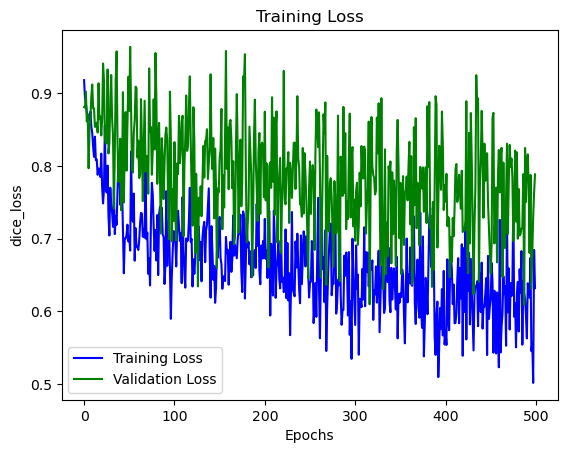

In [5]:
experiment.plot_loss()

In [14]:
import os
weights_dir = "/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/weights/"
name = '3-27-24_epochs500'
weights_path = os.path.join(weights_dir, name + '.pt')
torch.save(experiment.model.state_dict(), weights_path)

In [6]:
print(len(test_loader))

6


In [10]:
import matplotlib.pyplot as plt
def show_val():
    with torch.no_grad():
        fig, ax = plt.subplots(len(test_loader), 3, figsize=(12, 18))
        for i, data in enumerate(test_loader):
            img, label, file = data
            file = file[0]
            img = img.to(device)
            pred = model(img)
            pred = pred > 0.5
            
            img = img.to('cpu')
            img = img.squeeze()
            img = img.permute(1, 2, 0)
    
            label = label.squeeze()
                
            pred = pred.to('cpu')
            pred = pred.squeeze()
    
            ax[i, 0].imshow(img)
            ax[i, 0].axis('off')
            ax[i, 0].set_title("image")
            ax[i, 1].imshow(label, cmap='gray')
            ax[i, 1].axis('off')
            ax[i, 1].set_title("ground truth")
            ax[i, 2].imshow(pred, cmap='gray')
            ax[i, 2].axis('off')
            ax[i, 2].set_title("prediction")        

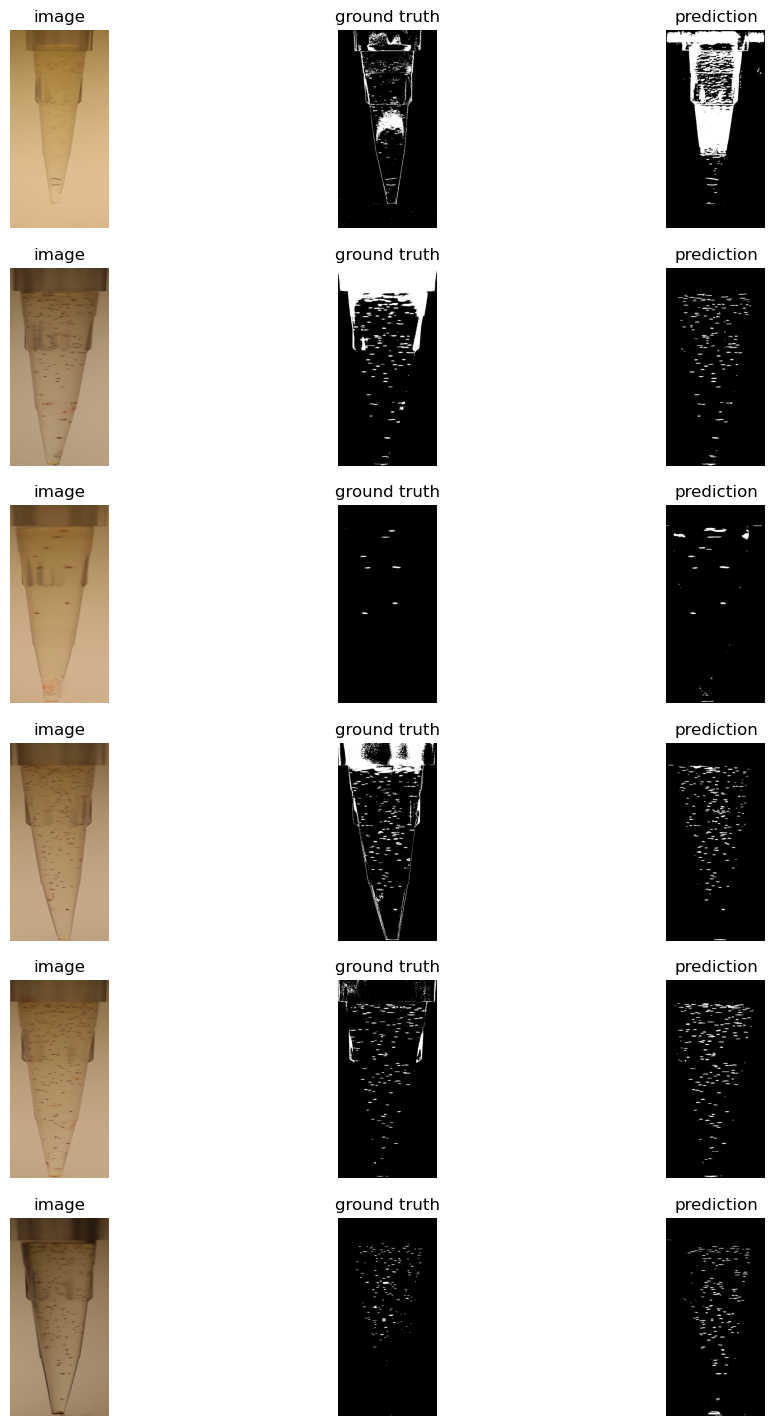

In [11]:
show_val()

0


In [16]:
experiment.starting_epoch = 500
experiment.train(train_loader=train_loader, validation_loader=test_loader, epochs=500)

Epoch 501/1000: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.634, loss=0.7


501/1000 train loss: 0.6339346766471863  val loss: 0.7206446329752604


Epoch 502/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.598, loss=0.5


502/1000 train loss: 0.597985585530599  val loss: 0.6873891949653625


Epoch 503/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.592, loss=0.6


503/1000 train loss: 0.5917930205663046  val loss: 0.7614980737368265


Epoch 504/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.616, loss=0.6


504/1000 train loss: 0.6162626643975576  val loss: 0.7866458296775818


Epoch 505/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.542, loss=0.7


505/1000 train loss: 0.5422896047433218  val loss: 0.6130074361960093


Epoch 506/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.624, loss=0.7


506/1000 train loss: 0.6244049370288849  val loss: 0.8426092565059662


Epoch 507/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.6, loss=0.574


507/1000 train loss: 0.6001494924227396  val loss: 0.7129347324371338


Epoch 508/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.669, loss=0.5


508/1000 train loss: 0.6692480941613516  val loss: 0.7926716407140096


Epoch 509/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.537, loss=0.6


509/1000 train loss: 0.5367145438989004  val loss: 0.7710715134938558


Epoch 510/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.701, loss=0.5


510/1000 train loss: 0.7008431255817413  val loss: 0.7961234052975973


Epoch 511/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.643, loss=0.6


511/1000 train loss: 0.6430481274922689  val loss: 0.781331072251002


Epoch 512/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.577, loss=0.3


512/1000 train loss: 0.5770812531312307  val loss: 0.8778600792090098


Epoch 513/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.571, loss=0.5


513/1000 train loss: 0.5710229277610779  val loss: 0.8012190361817678


Epoch 514/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.664, loss=0.4


514/1000 train loss: 0.6644090811411539  val loss: 0.7667505145072937


Epoch 515/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.578, loss=0.5


515/1000 train loss: 0.577981968720754  val loss: 0.6836231549580892


Epoch 516/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.582, loss=0.4


516/1000 train loss: 0.5816154181957245  val loss: 0.8014043072859446


Epoch 517/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.604, loss=0.3


517/1000 train loss: 0.6037752230962118  val loss: 0.7061056792736053


Epoch 518/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.585, loss=0.6


518/1000 train loss: 0.5848968327045441  val loss: 0.7128150463104248


Epoch 519/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.576, loss=0.4


519/1000 train loss: 0.5758181611696879  val loss: 0.8992863694826762


Epoch 520/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.662, loss=0.7


520/1000 train loss: 0.6618981262048086  val loss: 0.6936507225036621


Epoch 521/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.638, loss=0.5


521/1000 train loss: 0.6383330921332041  val loss: 0.7284833888212839


Epoch 522/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.583, loss=0.6


522/1000 train loss: 0.5831244885921478  val loss: 0.7708925207455953


Epoch 523/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.586, loss=0.5


523/1000 train loss: 0.5858011941115061  val loss: 0.7000883320967356


Epoch 524/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.609, loss=0.6


524/1000 train loss: 0.6093502938747406  val loss: 0.8151066899299622


Epoch 525/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.616, loss=0.8


525/1000 train loss: 0.615861843029658  val loss: 0.8120059470335642


Epoch 526/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.564, loss=0.4


526/1000 train loss: 0.5636824468771616  val loss: 0.8179475565751394


Epoch 527/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.614, loss=0.4


527/1000 train loss: 0.6138198574384054  val loss: 0.807861864566803


Epoch 528/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.554, loss=0.4


528/1000 train loss: 0.553503563006719  val loss: 0.6840885082880656


Epoch 529/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.607, loss=0.6


529/1000 train loss: 0.6072636047999064  val loss: 0.8129631380240122


Epoch 530/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.631, loss=0.4


530/1000 train loss: 0.6306899388631185  val loss: 0.779152899980545


Epoch 531/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.607, loss=0.8


531/1000 train loss: 0.6074409683545431  val loss: 0.7123754918575287


Epoch 532/1000: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.641, loss=0.8


532/1000 train loss: 0.6412599980831146  val loss: 0.7109081745147705


Epoch 533/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.57, loss=0.69


533/1000 train loss: 0.5696346561113993  val loss: 0.8171376287937164


Epoch 534/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.655, loss=0.7


534/1000 train loss: 0.6545136272907257  val loss: 0.6988998353481293


Epoch 535/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.564, loss=0.8


535/1000 train loss: 0.5644437273343405  val loss: 0.6970932384332021


Epoch 536/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.659, loss=0.5


536/1000 train loss: 0.6594513555367788  val loss: 0.7939441005388895


Epoch 537/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.619, loss=0.8


537/1000 train loss: 0.6193472146987915  val loss: 0.7746930221716563


Epoch 538/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.632, loss=0.4


538/1000 train loss: 0.6316516002019247  val loss: 0.6580369969209036


Epoch 539/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.602, loss=0.6


539/1000 train loss: 0.6019236544768015  val loss: 0.7909511129061381


Epoch 540/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.57, loss=0.77


540/1000 train loss: 0.5700847208499908  val loss: 0.6942391792933146


Epoch 541/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.506, loss=0.7


541/1000 train loss: 0.5057875116666158  val loss: 0.7565088371435801


Epoch 542/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.69, loss=0.90


542/1000 train loss: 0.6899335980415344  val loss: 0.782509575287501


Epoch 543/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.556, loss=0.7


543/1000 train loss: 0.5559211174647013  val loss: 0.6439506709575653


Epoch 544/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.649, loss=0.7


544/1000 train loss: 0.6491779883702596  val loss: 0.6777167022228241


Epoch 545/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.65, loss=0.39


545/1000 train loss: 0.6498399476210276  val loss: 0.7530554533004761


Epoch 546/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.687, loss=0.3


546/1000 train loss: 0.6865611970424652  val loss: 0.7832891941070557


Epoch 547/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.624, loss=0.4


547/1000 train loss: 0.6236604253451029  val loss: 0.7110847234725952


Epoch 548/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.56, loss=0.39


548/1000 train loss: 0.5597975353399912  val loss: 0.9022180338700613


Epoch 549/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.601, loss=0.8


549/1000 train loss: 0.6009755929311117  val loss: 0.7343495190143585


Epoch 550/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.589, loss=0.7


550/1000 train loss: 0.5889088908831278  val loss: 0.7119791011015574


Epoch 551/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.61, loss=0.51


551/1000 train loss: 0.6098644733428955  val loss: 0.7514830430348715


Epoch 552/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.655, loss=0.4


552/1000 train loss: 0.6553561389446259  val loss: 0.6566370030244192


Epoch 553/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.521, loss=0.5


553/1000 train loss: 0.5209245681762695  val loss: 0.8516828119754791


Epoch 554/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.55, loss=0.74


554/1000 train loss: 0.5498605569203695  val loss: 0.7596250077088674


Epoch 555/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.702, loss=0.4


555/1000 train loss: 0.702411025762558  val loss: 0.8367191056410471


Epoch 556/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.577, loss=0.5


556/1000 train loss: 0.5770547290643057  val loss: 0.771686057249705


Epoch 557/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.578, loss=0.5


557/1000 train loss: 0.5778931975364685  val loss: 0.7318504750728607


Epoch 558/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.655, loss=0.8


558/1000 train loss: 0.6553727189699808  val loss: 0.8209637304147085


Epoch 559/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.599, loss=0.4


559/1000 train loss: 0.5991443991661072  val loss: 0.7350977063179016


Epoch 560/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.652, loss=0.4


560/1000 train loss: 0.6517660518487295  val loss: 0.8115214904149374


Epoch 561/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.56, loss=0.55


561/1000 train loss: 0.5599497159322103  val loss: 0.690364013115565


Epoch 562/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.624, loss=0.8


562/1000 train loss: 0.624043474594752  val loss: 0.8489072720209757


Epoch 563/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.604, loss=0.6


563/1000 train loss: 0.603821744521459  val loss: 0.6713563799858093


Epoch 564/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.558, loss=0.5


564/1000 train loss: 0.5584848523139954  val loss: 0.8720904290676117


Epoch 565/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.638, loss=0.6


565/1000 train loss: 0.6383935511112213  val loss: 0.7212321956952413


Epoch 566/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.606, loss=0.3


566/1000 train loss: 0.605679045120875  val loss: 0.7188372910022736


Epoch 567/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.641, loss=0.6


567/1000 train loss: 0.6414856314659119  val loss: 0.8989756007989248


Epoch 568/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.696, loss=0.6


568/1000 train loss: 0.6963008642196655  val loss: 0.8290694057941437


Epoch 569/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.607, loss=0.4


569/1000 train loss: 0.6069824894269308  val loss: 0.8389109273751577


Epoch 570/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.568, loss=0.4


570/1000 train loss: 0.5676969985167185  val loss: 0.7022088865439097


Epoch 571/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.576, loss=0.5


571/1000 train loss: 0.576350192228953  val loss: 0.7588419218858083


Epoch 572/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.628, loss=0.7


572/1000 train loss: 0.6277915934721628  val loss: 0.7452337344487509


Epoch 573/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.609, loss=0.5


573/1000 train loss: 0.6089800894260406  val loss: 0.8821488817532858


Epoch 574/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.63, loss=0.53


574/1000 train loss: 0.6300613085428873  val loss: 0.7300280332565308


Epoch 575/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.648, loss=0.4


575/1000 train loss: 0.6483546296755472  val loss: 0.827143798271815


Epoch 576/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.638, loss=0.6


576/1000 train loss: 0.6378540496031443  val loss: 0.7045288980007172


Epoch 577/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.589, loss=0.6


577/1000 train loss: 0.588916003704071  val loss: 0.6469076573848724


Epoch 578/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.545, loss=0.5


578/1000 train loss: 0.5446075002352396  val loss: 0.7308329343795776


Epoch 579/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.513, loss=0.4


579/1000 train loss: 0.512595534324646  val loss: 0.7946801980336508


Epoch 580/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.612, loss=0.4


580/1000 train loss: 0.611805647611618  val loss: 0.8106860816478729


Epoch 581/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.588, loss=0.7


581/1000 train loss: 0.5881479779879252  val loss: 0.9094942311445872


Epoch 582/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.634, loss=0.7


582/1000 train loss: 0.6341341733932495  val loss: 0.7704692880312601


Epoch 583/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.643, loss=0.9


583/1000 train loss: 0.6428492764631907  val loss: 0.732647180557251


Epoch 584/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.553, loss=0.4


584/1000 train loss: 0.5526578823725382  val loss: 0.8544336458047231


Epoch 585/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.587, loss=0.5


585/1000 train loss: 0.5871043304602305  val loss: 0.6709190706411997


Epoch 586/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.61, loss=0.37


586/1000 train loss: 0.6096038818359375  val loss: 0.7300543089707693


Epoch 587/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.627, loss=0.5


587/1000 train loss: 0.6269101401170095  val loss: 0.9196851551532745


Epoch 588/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.521, loss=0.7


588/1000 train loss: 0.5213852922121683  val loss: 0.7427871425946554


Epoch 589/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.561, loss=0.7


589/1000 train loss: 0.561219185590744  val loss: 0.8085776368776957


Epoch 590/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.611, loss=0.4


590/1000 train loss: 0.6111621956030527  val loss: 0.7798606554667155


Epoch 591/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.603, loss=0.7


591/1000 train loss: 0.6034183402856191  val loss: 0.8297594288984934


Epoch 592/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.643, loss=0.7


592/1000 train loss: 0.6431577006975809  val loss: 0.6891080935796102


Epoch 593/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.617, loss=0.5


593/1000 train loss: 0.6170488893985748  val loss: 0.7571285863717397


Epoch 594/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.562, loss=0.4


594/1000 train loss: 0.5618065297603607  val loss: 0.7073178092638651


Epoch 595/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.582, loss=0.5


595/1000 train loss: 0.5820192495981852  val loss: 0.8111768166224161


Epoch 596/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.618, loss=0.7


596/1000 train loss: 0.6183158854643503  val loss: 0.8236971199512482


Epoch 597/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.604, loss=0.6


597/1000 train loss: 0.6039911607901255  val loss: 0.6982475916544596


Epoch 598/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.504, loss=0.6


598/1000 train loss: 0.5035183429718018  val loss: 0.6650345822175344


Epoch 599/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.662, loss=0.7


599/1000 train loss: 0.6616886456807455  val loss: 0.7076103389263153


Epoch 600/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.581, loss=0.6


600/1000 train loss: 0.5806925098101298  val loss: 0.7011798918247223


Epoch 601/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.642, loss=0.5


601/1000 train loss: 0.6416599055131277  val loss: 0.6146973371505737


Epoch 602/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.513, loss=0.5


602/1000 train loss: 0.5134393175443014  val loss: 0.6991481184959412


Epoch 603/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.646, loss=0.4


603/1000 train loss: 0.6464267869790395  val loss: 0.8019892374674479


Epoch 604/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.515, loss=0.5


604/1000 train loss: 0.5150573452313741  val loss: 0.8056535919507345


Epoch 605/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.573, loss=0.6


605/1000 train loss: 0.5730700592199961  val loss: 0.7745770315329233


Epoch 606/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.518, loss=0.3


606/1000 train loss: 0.5177245835463206  val loss: 0.869092583656311


Epoch 607/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.565, loss=0.8


607/1000 train loss: 0.5646975636482239  val loss: 0.8234291672706604


Epoch 608/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.558, loss=0.5


608/1000 train loss: 0.558467815319697  val loss: 0.6456682980060577


Epoch 609/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.641, loss=0.6


609/1000 train loss: 0.6407995422681173  val loss: 0.8273685276508331


Epoch 610/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.647, loss=0.7


610/1000 train loss: 0.6474602818489075  val loss: 0.7154163817564646


Epoch 611/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.602, loss=0.3


611/1000 train loss: 0.6016392111778259  val loss: 0.7825991213321686


Epoch 612/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.505, loss=0.5


612/1000 train loss: 0.5053398509820303  val loss: 0.7276950180530548


Epoch 613/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.606, loss=0.6


613/1000 train loss: 0.6059809029102325  val loss: 0.6499005655447642


Epoch 614/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.582, loss=0.5


614/1000 train loss: 0.5821220278739929  val loss: 0.8611467083295187


Epoch 615/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.618, loss=0.7


615/1000 train loss: 0.6183580656846365  val loss: 0.7129467527071635


Epoch 616/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.537, loss=0.4


616/1000 train loss: 0.536644329627355  val loss: 0.7140833536783854


Epoch 617/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.529, loss=0.7


617/1000 train loss: 0.5290780067443848  val loss: 0.7904388109842936


Epoch 618/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.581, loss=0.4


618/1000 train loss: 0.5806125501791636  val loss: 0.7268855373064677


Epoch 619/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.532, loss=0.4


619/1000 train loss: 0.5320973992347717  val loss: 0.5965253412723541


Epoch 620/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.58, loss=0.76


620/1000 train loss: 0.5796754757563273  val loss: 0.6993992229302725


Epoch 621/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.644, loss=0.7


621/1000 train loss: 0.644461452960968  val loss: 0.714350293080012


Epoch 622/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.567, loss=0.4


622/1000 train loss: 0.5670477549235026  val loss: 0.6248611609141032


Epoch 623/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.578, loss=0.4


623/1000 train loss: 0.5781592130661011  val loss: 0.7194238603115082


Epoch 624/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.567, loss=0.4


624/1000 train loss: 0.5666686991850535  val loss: 0.5994382301966349


Epoch 625/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.571, loss=0.6


625/1000 train loss: 0.5714820921421051  val loss: 0.6102703511714935


Epoch 626/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.585, loss=0.5


626/1000 train loss: 0.5851309994856516  val loss: 0.747849186261495


Epoch 627/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.515, loss=0.7


627/1000 train loss: 0.5152948995431265  val loss: 0.796086182196935


Epoch 628/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.564, loss=0.8


628/1000 train loss: 0.564201831817627  val loss: 0.8112009267012278


Epoch 629/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.56, loss=0.82


629/1000 train loss: 0.5597901443640391  val loss: 0.7969449659188589


Epoch 630/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.659, loss=0.3


630/1000 train loss: 0.6590617001056671  val loss: 0.7105635702610016


Epoch 631/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.555, loss=0.5


631/1000 train loss: 0.5552851359049479  val loss: 0.8732849558194479


Epoch 632/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.542, loss=0.6


632/1000 train loss: 0.5422639747460684  val loss: 0.8212347626686096


Epoch 633/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.565, loss=0.4


633/1000 train loss: 0.5652997096379598  val loss: 0.6501107315222422


Epoch 634/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.661, loss=0.5


634/1000 train loss: 0.6611968477567037  val loss: 0.7679547965526581


Epoch 635/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.519, loss=0.7


635/1000 train loss: 0.5187675654888153  val loss: 0.7641164859135946


Epoch 636/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.612, loss=0.8


636/1000 train loss: 0.6122340460618337  val loss: 0.6703067223230997


Epoch 637/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.583, loss=0.4


637/1000 train loss: 0.5831941167513529  val loss: 0.790468841791153


Epoch 638/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.567, loss=0.4


638/1000 train loss: 0.5673735936482748  val loss: 0.9411391119162241


Epoch 639/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.59, loss=0.61


639/1000 train loss: 0.5898300111293793  val loss: 0.7846807142098745


Epoch 640/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.566, loss=0.3


640/1000 train loss: 0.5664659440517426  val loss: 0.8068326810995737


Epoch 641/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.616, loss=0.7


641/1000 train loss: 0.6160796284675598  val loss: 0.930700957775116


Epoch 642/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.597, loss=0.5


642/1000 train loss: 0.5969024995962778  val loss: 0.6895588239034017


Epoch 643/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.556, loss=0.6


643/1000 train loss: 0.5560214221477509  val loss: 0.7878956298033396


Epoch 644/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.601, loss=0.4


644/1000 train loss: 0.6014914015928904  val loss: 0.6368074417114258


Epoch 645/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.516, loss=0.5


645/1000 train loss: 0.5157372156778971  val loss: 0.7428109149138132


Epoch 646/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.557, loss=0.4


646/1000 train loss: 0.556820809841156  val loss: 0.7202807664871216


Epoch 647/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.556, loss=0.6


647/1000 train loss: 0.5560787717501322  val loss: 0.7070641020933787


Epoch 648/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.625, loss=0.4


648/1000 train loss: 0.6249034702777863  val loss: 0.7799824774265289


Epoch 649/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.581, loss=0.6


649/1000 train loss: 0.5806726217269897  val loss: 0.7291062573591868


Epoch 650/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.555, loss=0.5


650/1000 train loss: 0.5552976032098135  val loss: 0.7175323963165283


Epoch 651/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.583, loss=0.5


651/1000 train loss: 0.5829864343007406  val loss: 0.7487456003824869


Epoch 652/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.616, loss=0.7


652/1000 train loss: 0.6159745256106058  val loss: 0.7091277639071146


Epoch 653/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.58, loss=0.63


653/1000 train loss: 0.5801555514335632  val loss: 0.8399518132209778


Epoch 654/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.555, loss=0.4


654/1000 train loss: 0.5551296273867289  val loss: 0.7122013966242472


Epoch 655/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.584, loss=0.4


655/1000 train loss: 0.5844660401344299  val loss: 0.6877677241961161


Epoch 656/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.604, loss=0.5


656/1000 train loss: 0.6038252810637156  val loss: 0.7121179203192393


Epoch 657/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.639, loss=0.8


657/1000 train loss: 0.6386695702870687  val loss: 0.8056970338026682


Epoch 658/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.541, loss=0.6


658/1000 train loss: 0.5414143900076548  val loss: 0.8706348836421967


Epoch 659/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.594, loss=0.4


659/1000 train loss: 0.5940414667129517  val loss: 0.736974855264028


Epoch 660/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.533, loss=0.5


660/1000 train loss: 0.5328142046928406  val loss: 0.7903852661450704


Epoch 661/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.629, loss=0.4


661/1000 train loss: 0.6286332607269287  val loss: 0.8292231559753418


Epoch 662/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.587, loss=0.6


662/1000 train loss: 0.586966335773468  val loss: 0.6837247908115387


Epoch 663/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.543, loss=0.3


663/1000 train loss: 0.5430618524551392  val loss: 0.7126759092013041


Epoch 664/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.555, loss=0.4


664/1000 train loss: 0.5552322069803873  val loss: 0.806425134340922


Epoch 665/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.48, loss=0.58


665/1000 train loss: 0.4796972970167796  val loss: 0.6940931379795074


Epoch 666/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.561, loss=0.4


666/1000 train loss: 0.5609287222226461  val loss: 0.7629780570665995


Epoch 667/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.609, loss=0.6


667/1000 train loss: 0.6093633870283762  val loss: 0.7085663874944051


Epoch 668/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.503, loss=0.4


668/1000 train loss: 0.5025601486365  val loss: 0.7363348603248596


Epoch 669/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.644, loss=0.7


669/1000 train loss: 0.6436370114485422  val loss: 0.7407513558864594


Epoch 670/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.57, loss=0.77


670/1000 train loss: 0.5704743266105652  val loss: 0.7116188406944275


Epoch 671/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.603, loss=0.5


671/1000 train loss: 0.6034879187742869  val loss: 0.7980426947275797


Epoch 672/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.611, loss=0.4


672/1000 train loss: 0.6108157436052958  val loss: 0.8863104184468588


Epoch 673/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.576, loss=0.7


673/1000 train loss: 0.5762452781200409  val loss: 0.8978104889392853


Epoch 674/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.487, loss=0.4


674/1000 train loss: 0.4865390658378601  val loss: 0.6743652125199636


Epoch 675/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.629, loss=0.7


675/1000 train loss: 0.6285302639007568  val loss: 0.7093262076377869


Epoch 676/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.587, loss=0.7


676/1000 train loss: 0.5870943466822306  val loss: 0.7228284180164337


Epoch 677/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.533, loss=0.5


677/1000 train loss: 0.5334407687187195  val loss: 0.9253539343674978


Epoch 678/1000: 100%|█| 6/6 [00:05<00:00,  1.11batch/s, avg_loss=0.604, loss=0.4


678/1000 train loss: 0.6039942602316538  val loss: 0.6869427164395651


Epoch 679/1000: 100%|█| 6/6 [00:05<00:00,  1.12batch/s, avg_loss=0.581, loss=0.4


679/1000 train loss: 0.5806330144405365  val loss: 0.7127499679724375


Epoch 680/1000: 100%|█| 6/6 [00:05<00:00,  1.17batch/s, avg_loss=0.589, loss=0.5


680/1000 train loss: 0.5888691345850626  val loss: 0.6094717482725779


Epoch 681/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.585, loss=0.4


681/1000 train loss: 0.5847394565741221  val loss: 0.7119886676470438


Epoch 682/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.509, loss=0.4


682/1000 train loss: 0.5094690124193827  val loss: 0.6691963374614716


Epoch 683/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.532, loss=0.5


683/1000 train loss: 0.5316483775774637  val loss: 0.8271305163701376


Epoch 684/1000: 100%|█| 6/6 [00:05<00:00,  1.14batch/s, avg_loss=0.561, loss=0.7


684/1000 train loss: 0.5605579713980356  val loss: 0.6973131398359934


Epoch 685/1000: 100%|█| 6/6 [00:05<00:00,  1.14batch/s, avg_loss=0.565, loss=0.4


685/1000 train loss: 0.5649213592211405  val loss: 0.6857744256655375


Epoch 686/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.607, loss=0.6


686/1000 train loss: 0.6070672571659088  val loss: 0.7897782325744629


Epoch 687/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.621, loss=0.6


687/1000 train loss: 0.621165007352829  val loss: 0.82504669825236


Epoch 688/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.554, loss=0.4


688/1000 train loss: 0.5544449090957642  val loss: 0.8937933544317881


Epoch 689/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.514, loss=0.9


689/1000 train loss: 0.5138379534085592  val loss: 0.7398788134256998


Epoch 690/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.543, loss=0.3


690/1000 train loss: 0.5432474315166473  val loss: 0.7467840512593588


Epoch 691/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.544, loss=0.6


691/1000 train loss: 0.5443779428799947  val loss: 0.8013202548027039


Epoch 692/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.587, loss=0.8


692/1000 train loss: 0.5873373647530874  val loss: 0.6124114096164703


Epoch 693/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.515, loss=0.4


693/1000 train loss: 0.5147331754366556  val loss: 0.728845218817393


Epoch 694/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.513, loss=0.5


694/1000 train loss: 0.5129614869753519  val loss: 0.7496044536431631


Epoch 695/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.561, loss=0.5


695/1000 train loss: 0.5608810782432556  val loss: 0.7744295199712118


Epoch 696/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.548, loss=0.7


696/1000 train loss: 0.5476334393024445  val loss: 0.5782206753889719


Epoch 697/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.549, loss=0.3


697/1000 train loss: 0.5490262309710184  val loss: 0.6186912258466085


Epoch 698/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.55, loss=0.66


698/1000 train loss: 0.5499528547128042  val loss: 0.7737769683202108


Epoch 699/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.592, loss=0.6


699/1000 train loss: 0.5919990738232931  val loss: 0.8426078061262766


Epoch 700/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.495, loss=0.6


700/1000 train loss: 0.49516546726226807  val loss: 0.875375101963679


Epoch 701/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.624, loss=0.4


701/1000 train loss: 0.623930017153422  val loss: 0.7927695711453756


Epoch 702/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.579, loss=0.5


702/1000 train loss: 0.5791541238625845  val loss: 0.831756720940272


Epoch 703/1000: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.597, loss=0.6


703/1000 train loss: 0.5966445604960123  val loss: 0.7074719667434692


Epoch 704/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.48, loss=0.70


704/1000 train loss: 0.48019444942474365  val loss: 0.7707123458385468


Epoch 705/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.65, loss=0.78


705/1000 train loss: 0.6499061783154806  val loss: 0.7764669756094614


Epoch 706/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.582, loss=0.8


706/1000 train loss: 0.5816467305024465  val loss: 0.8630776902039846


Epoch 707/1000: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.54, loss=0.63


707/1000 train loss: 0.5402843554814657  val loss: 0.714034914970398


Epoch 708/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.556, loss=0.7


708/1000 train loss: 0.5560111800829569  val loss: 0.8327055275440216


Epoch 709/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.514, loss=0.5


709/1000 train loss: 0.5140231251716614  val loss: 0.7254391113917033


Epoch 710/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.571, loss=0.4


710/1000 train loss: 0.5707488358020782  val loss: 0.7673311630884806


Epoch 711/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.604, loss=0.4


711/1000 train loss: 0.6035187542438507  val loss: 0.8347182671229044


Epoch 712/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.55, loss=0.54


712/1000 train loss: 0.5501503249009451  val loss: 0.6112525860468546


Epoch 713/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.537, loss=0.4


713/1000 train loss: 0.5367571512858073  val loss: 0.7053096294403076


Epoch 714/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.586, loss=0.5


714/1000 train loss: 0.5862311919530233  val loss: 0.788038561741511


Epoch 715/1000: 100%|█| 6/6 [00:05<00:00,  1.12batch/s, avg_loss=0.61, loss=0.87


715/1000 train loss: 0.6101692120234171  val loss: 0.6240954995155334


Epoch 716/1000: 100%|█| 6/6 [00:05<00:00,  1.12batch/s, avg_loss=0.481, loss=0.4


716/1000 train loss: 0.4809277057647705  val loss: 0.7957543631394705


Epoch 717/1000: 100%|█| 6/6 [00:05<00:00,  1.14batch/s, avg_loss=0.512, loss=0.3


717/1000 train loss: 0.5120589236418406  val loss: 0.8624010185400645


Epoch 718/1000: 100%|█| 6/6 [00:05<00:00,  1.17batch/s, avg_loss=0.539, loss=0.6


718/1000 train loss: 0.5387800534566244  val loss: 0.7099798520406088


Epoch 719/1000: 100%|█| 6/6 [00:05<00:00,  1.18batch/s, avg_loss=0.602, loss=0.6


719/1000 train loss: 0.6018255054950714  val loss: 0.7185529867808024


Epoch 720/1000: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.526, loss=0.3


720/1000 train loss: 0.5256245533625284  val loss: 0.6987687249978384


Epoch 721/1000: 100%|█| 6/6 [00:05<00:00,  1.17batch/s, avg_loss=0.599, loss=0.6


721/1000 train loss: 0.5987209180990855  val loss: 0.6948424279689789


Epoch 722/1000: 100%|█| 6/6 [00:04<00:00,  1.20batch/s, avg_loss=0.622, loss=0.6


722/1000 train loss: 0.6220265924930573  val loss: 0.7613996466000875


Epoch 723/1000: 100%|█| 6/6 [00:05<00:00,  1.18batch/s, avg_loss=0.589, loss=0.5


723/1000 train loss: 0.5886603395144144  val loss: 0.619967391093572


Epoch 724/1000: 100%|█| 6/6 [00:04<00:00,  1.21batch/s, avg_loss=0.555, loss=0.7


724/1000 train loss: 0.5551678041617075  val loss: 0.7862963775793711


Epoch 725/1000: 100%|█| 6/6 [00:05<00:00,  1.19batch/s, avg_loss=0.489, loss=0.6


725/1000 train loss: 0.48881644010543823  val loss: 0.7943237026532491


Epoch 726/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.578, loss=0.4


726/1000 train loss: 0.5784107446670532  val loss: 0.717559297879537


Epoch 727/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.603, loss=0.6


727/1000 train loss: 0.6030967930952708  val loss: 0.7323886950810751


Epoch 728/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.57, loss=0.35


728/1000 train loss: 0.5701221426328024  val loss: 0.6931652923425039


Epoch 729/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.532, loss=0.6


729/1000 train loss: 0.5317380428314209  val loss: 0.6934792300065359


Epoch 730/1000: 100%|█| 6/6 [00:05<00:00,  1.15batch/s, avg_loss=0.482, loss=0.4


730/1000 train loss: 0.4823896288871765  val loss: 0.7910001774628957


Epoch 731/1000: 100%|█| 6/6 [00:05<00:00,  1.18batch/s, avg_loss=0.506, loss=0.6


731/1000 train loss: 0.5062321027119955  val loss: 0.700526624917984


Epoch 732/1000: 100%|█| 6/6 [00:04<00:00,  1.21batch/s, avg_loss=0.496, loss=0.4


732/1000 train loss: 0.49557427565256756  val loss: 0.7863719165325165


Epoch 733/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.507, loss=0.6


733/1000 train loss: 0.5070786972840627  val loss: 0.8315927386283875


Epoch 734/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.522, loss=0.6


734/1000 train loss: 0.5222356120745341  val loss: 0.6120745042959849


Epoch 735/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.416, loss=0.3


735/1000 train loss: 0.4158184230327606  val loss: 0.7105682094891866


Epoch 736/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.602, loss=0.6


736/1000 train loss: 0.6024590333302816  val loss: 0.8967789113521576


Epoch 737/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.607, loss=0.8


737/1000 train loss: 0.6069685916105906  val loss: 0.7318926552931467


Epoch 738/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.581, loss=0.8


738/1000 train loss: 0.5806212524573008  val loss: 0.768287350734075


Epoch 739/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.552, loss=0.8


739/1000 train loss: 0.5518515110015869  val loss: 0.8085554540157318


Epoch 740/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.636, loss=0.4


740/1000 train loss: 0.6364501516024271  val loss: 0.7768656114737192


Epoch 741/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.498, loss=0.6


741/1000 train loss: 0.498332937558492  val loss: 0.7313513259092966


Epoch 742/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.519, loss=0.6


742/1000 train loss: 0.5188061992327372  val loss: 0.8119931320349375


Epoch 743/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.533, loss=0.6


743/1000 train loss: 0.5328991313775381  val loss: 0.7072507441043854


Epoch 744/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.559, loss=0.6


744/1000 train loss: 0.5586098829905192  val loss: 0.8009237150351206


Epoch 745/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.523, loss=0.8


745/1000 train loss: 0.5234820743401846  val loss: 0.8688210149606069


Epoch 746/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.593, loss=0.6


746/1000 train loss: 0.5930164456367493  val loss: 0.7055155833562216


Epoch 747/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.582, loss=0.8


747/1000 train loss: 0.5819485783576965  val loss: 0.7570313711961111


Epoch 748/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.563, loss=0.6


748/1000 train loss: 0.5631300111611685  val loss: 0.9191063841183981


Epoch 749/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.583, loss=0.4


749/1000 train loss: 0.5827133258183798  val loss: 0.8302377065022787


Epoch 750/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.536, loss=0.5


750/1000 train loss: 0.5359472235043844  val loss: 0.7958616614341736


Epoch 751/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.617, loss=0.7


751/1000 train loss: 0.6174241900444031  val loss: 0.7039138476053873


Epoch 752/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.483, loss=0.5


752/1000 train loss: 0.4833566149075826  val loss: 0.7165457308292389


Epoch 753/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.578, loss=0.4


753/1000 train loss: 0.5782940983772278  val loss: 0.8265730341275533


Epoch 754/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.508, loss=0.8


754/1000 train loss: 0.507907638947169  val loss: 0.6670289138952891


Epoch 755/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.619, loss=0.4


755/1000 train loss: 0.6194015940030416  val loss: 0.7195426722367605


Epoch 756/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.566, loss=0.5


756/1000 train loss: 0.5662330687046051  val loss: 0.7680431008338928


Epoch 757/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.61, loss=0.85


757/1000 train loss: 0.6101512710253397  val loss: 0.617883155743281


Epoch 758/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.593, loss=0.6


758/1000 train loss: 0.5934041440486908  val loss: 0.5967589219411215


Epoch 759/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.615, loss=0.7


759/1000 train loss: 0.6149126688639323  val loss: 0.8097833693027496


Epoch 760/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.563, loss=0.3


760/1000 train loss: 0.5631525913874308  val loss: 0.6785158713658651


Epoch 761/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.684, loss=0.6


761/1000 train loss: 0.6838589708010355  val loss: 0.7081379989782969


Epoch 762/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.53, loss=0.38


762/1000 train loss: 0.5299390455087026  val loss: 0.6510443091392517


Epoch 763/1000: 100%|█| 6/6 [00:04<00:00,  1.22batch/s, avg_loss=0.589, loss=0.3


763/1000 train loss: 0.5885287125905355  val loss: 0.7962969243526459


Epoch 764/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.497, loss=0.5


764/1000 train loss: 0.4969861110051473  val loss: 0.7784977753957113


Epoch 765/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.497, loss=0.6


765/1000 train loss: 0.4965127905209859  val loss: 0.7616356909275055


Epoch 766/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.594, loss=0.6


766/1000 train loss: 0.5943702459335327  val loss: 0.6548440953095754


Epoch 767/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.591, loss=0.5


767/1000 train loss: 0.5910523136456808  val loss: 0.7424295743306478


Epoch 768/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.531, loss=0.4


768/1000 train loss: 0.5308481951554617  val loss: 0.7777152061462402


Epoch 769/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.509, loss=0.4


769/1000 train loss: 0.5093815426031748  val loss: 0.8045639097690582


Epoch 770/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.584, loss=0.5


770/1000 train loss: 0.5838710168997446  val loss: 0.7169075310230255


Epoch 771/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.56, loss=0.43


771/1000 train loss: 0.559976746638616  val loss: 0.7070423563321432


Epoch 772/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.514, loss=0.7


772/1000 train loss: 0.5141744812329611  val loss: 0.6344630718231201


Epoch 773/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.464, loss=0.3


773/1000 train loss: 0.4637296100457509  val loss: 0.792700876792272


Epoch 774/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.592, loss=0.3


774/1000 train loss: 0.592323491970698  val loss: 0.752162367105484


Epoch 775/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.555, loss=0.6


775/1000 train loss: 0.5549740195274353  val loss: 0.7072759469350179


Epoch 776/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.521, loss=0.4


776/1000 train loss: 0.5213047464688619  val loss: 0.9086156288782755


Epoch 777/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.567, loss=0.5


777/1000 train loss: 0.5669495761394501  val loss: 0.7572350104649862


Epoch 778/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.59, loss=0.54


778/1000 train loss: 0.5895126660664877  val loss: 0.8258117437362671


Epoch 779/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.467, loss=0.6


779/1000 train loss: 0.4669201076030731  val loss: 0.8283176819483439


Epoch 780/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.609, loss=0.3


780/1000 train loss: 0.6088115572929382  val loss: 0.8063225150108337


Epoch 781/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.578, loss=0.4


781/1000 train loss: 0.5777168273925781  val loss: 0.8114093641440073


Epoch 782/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.491, loss=0.4


782/1000 train loss: 0.4914582371711731  val loss: 0.7603257199128469


Epoch 783/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.639, loss=0.6


783/1000 train loss: 0.6392110387484232  val loss: 0.7599936823050181


Epoch 784/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.552, loss=0.5


784/1000 train loss: 0.5519658525784811  val loss: 0.7627204060554504


Epoch 785/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.455, loss=0.5


785/1000 train loss: 0.4550113578637441  val loss: 0.7216383020083109


Epoch 786/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.499, loss=0.5


786/1000 train loss: 0.49885741869608563  val loss: 0.8394803106784821


Epoch 787/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.526, loss=0.6


787/1000 train loss: 0.5256344377994537  val loss: 0.5948419670263926


Epoch 788/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.539, loss=0.6


788/1000 train loss: 0.5385429660479227  val loss: 0.6309539179007212


Epoch 789/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.495, loss=0.6


789/1000 train loss: 0.4954146941502889  val loss: 0.8819665908813477


Epoch 790/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.529, loss=0.4


790/1000 train loss: 0.529283344745636  val loss: 0.7361726959546407


Epoch 791/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.452, loss=0.3


791/1000 train loss: 0.4516660273075104  val loss: 0.7285387317339579


Epoch 792/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.545, loss=0.5


792/1000 train loss: 0.5451292196909586  val loss: 0.8697989284992218


Epoch 793/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.517, loss=0.4


793/1000 train loss: 0.5169998308022817  val loss: 0.7421546081701914


Epoch 794/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.588, loss=0.3


794/1000 train loss: 0.5884838998317719  val loss: 0.7665318548679352


Epoch 795/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.557, loss=0.7


795/1000 train loss: 0.5570522546768188  val loss: 0.8055455684661865


Epoch 796/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.617, loss=0.4


796/1000 train loss: 0.6173142492771149  val loss: 0.6887195408344269


Epoch 797/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.508, loss=0.3


797/1000 train loss: 0.5083136856555939  val loss: 0.772229810555776


Epoch 798/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.468, loss=0.7


798/1000 train loss: 0.4681859811147054  val loss: 0.8012974758942922


Epoch 799/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.623, loss=0.6


799/1000 train loss: 0.6233852704366049  val loss: 0.79230264822642


Epoch 800/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.442, loss=0.4


800/1000 train loss: 0.4416600962479909  val loss: 0.8863159716129303


Epoch 801/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.489, loss=0.3


801/1000 train loss: 0.4892818331718445  val loss: 0.7951425711313883


Epoch 802/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.536, loss=0.5


802/1000 train loss: 0.5362703005472819  val loss: 0.8044751683870951


Epoch 803/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.585, loss=0.7


803/1000 train loss: 0.5851399004459381  val loss: 0.8308442334334055


Epoch 804/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.59, loss=0.40


804/1000 train loss: 0.5896957814693451  val loss: 0.6789095004399618


Epoch 805/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.54, loss=0.46


805/1000 train loss: 0.539715419212977  val loss: 0.7906108299891154


Epoch 806/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.517, loss=0.4


806/1000 train loss: 0.5169693529605865  val loss: 0.7840773363908132


Epoch 807/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.528, loss=0.4


807/1000 train loss: 0.5281325578689575  val loss: 0.7755643129348755


Epoch 808/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.473, loss=0.3


808/1000 train loss: 0.4733007252216339  val loss: 0.7768626312414805


Epoch 809/1000: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.535, loss=0.4


809/1000 train loss: 0.534518281618754  val loss: 0.7180586556593577


Epoch 810/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.572, loss=0.6


810/1000 train loss: 0.5719430347283682  val loss: 0.7319316069285074


Epoch 811/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.508, loss=0.4


811/1000 train loss: 0.50758429368337  val loss: 0.7364726861317953


Epoch 812/1000: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.463, loss=0.3


812/1000 train loss: 0.4629659652709961  val loss: 0.6961537698904673


Epoch 813/1000: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.488, loss=0.3


813/1000 train loss: 0.48770766456921893  val loss: 0.7215704321861267


Epoch 814/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.521, loss=0.4


814/1000 train loss: 0.5211687882741293  val loss: 0.8846394022305807


Epoch 815/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.485, loss=0.5


815/1000 train loss: 0.485315481821696  val loss: 0.7290484507878622


Epoch 816/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.507, loss=0.4


816/1000 train loss: 0.5072855055332184  val loss: 0.7134565313657125


Epoch 817/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.467, loss=0.4


817/1000 train loss: 0.4672934214274089  val loss: 0.8677265445391337


Epoch 818/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.457, loss=0.5


818/1000 train loss: 0.4565492073694865  val loss: 0.7516367534796397


Epoch 819/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.516, loss=0.6


819/1000 train loss: 0.5162731409072876  val loss: 0.8264289796352386


Epoch 820/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.58, loss=0.70


820/1000 train loss: 0.5800529917081197  val loss: 0.695758044719696


Epoch 821/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.592, loss=0.4


821/1000 train loss: 0.5921307901541392  val loss: 0.8267753024895986


Epoch 822/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.581, loss=0.7


822/1000 train loss: 0.5805932382742564  val loss: 0.7175049881140391


Epoch 823/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.55, loss=0.57


823/1000 train loss: 0.5496133665243784  val loss: 0.7455912530422211


Epoch 824/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.568, loss=0.6


824/1000 train loss: 0.5682436227798462  val loss: 0.7030463616053263


Epoch 825/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.529, loss=0.4


825/1000 train loss: 0.5286764899889628  val loss: 0.8035408159097036


Epoch 826/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.557, loss=0.8


826/1000 train loss: 0.5568172832330068  val loss: 0.7465535700321198


Epoch 827/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.599, loss=0.6


827/1000 train loss: 0.5992545286814371  val loss: 0.6916335125764211


Epoch 828/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.527, loss=0.6


828/1000 train loss: 0.5274510979652405  val loss: 0.8340552647908529


Epoch 829/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.593, loss=0.6


829/1000 train loss: 0.5931718051433563  val loss: 0.7556321024894714


Epoch 830/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.603, loss=0.5


830/1000 train loss: 0.6025050580501556  val loss: 0.837350050608317


Epoch 831/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.521, loss=0.4


831/1000 train loss: 0.5211242039998373  val loss: 0.784603993097941


Epoch 832/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.519, loss=0.7


832/1000 train loss: 0.5188613533973694  val loss: 0.7550596296787262


Epoch 833/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.496, loss=0.3


833/1000 train loss: 0.49632908900578815  val loss: 0.7539255519707998


Epoch 834/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.473, loss=0.4


834/1000 train loss: 0.47253434856732685  val loss: 0.8317940731843313


Epoch 835/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.564, loss=0.5


835/1000 train loss: 0.5644033253192902  val loss: 0.9056584139664968


Epoch 836/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.48, loss=0.56


836/1000 train loss: 0.4803227285544078  val loss: 0.8061867952346802


Epoch 837/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.497, loss=0.4


837/1000 train loss: 0.49712325135866803  val loss: 0.7339281241099039


Epoch 838/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.523, loss=0.5


838/1000 train loss: 0.5231023927529653  val loss: 0.833569606145223


Epoch 839/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.499, loss=0.3


839/1000 train loss: 0.4988243480523427  val loss: 0.9216862420241038


Epoch 840/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.525, loss=0.5


840/1000 train loss: 0.5251199503739675  val loss: 0.7199590802192688


Epoch 841/1000: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.475, loss=0.4


841/1000 train loss: 0.4745309253533681  val loss: 0.8321043451627096


Epoch 842/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.552, loss=0.3


842/1000 train loss: 0.5523377358913422  val loss: 0.7094475626945496


Epoch 843/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.46, loss=0.54


843/1000 train loss: 0.45962977409362793  val loss: 0.6651892066001892


Epoch 844/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.57, loss=0.44


844/1000 train loss: 0.5698651472727457  val loss: 0.8020232121149699


Epoch 845/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.499, loss=0.5


845/1000 train loss: 0.4990127185980479  val loss: 0.9073111812273661


Epoch 846/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.5, loss=0.574


846/1000 train loss: 0.4998069604237874  val loss: 0.878894696633021


Epoch 847/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.47, loss=0.48


847/1000 train loss: 0.4695911506811778  val loss: 0.7849549055099487


Epoch 848/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.52, loss=0.48


848/1000 train loss: 0.5199389060338339  val loss: 0.9101456999778748


Epoch 849/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.474, loss=0.4


849/1000 train loss: 0.4735368986924489  val loss: 0.735366036494573


Epoch 850/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.57, loss=0.56


850/1000 train loss: 0.5704768697420756  val loss: 0.728456715742747


Epoch 851/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.629, loss=0.5


851/1000 train loss: 0.6293181876341502  val loss: 0.7100622852643331


Epoch 852/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.515, loss=0.5


852/1000 train loss: 0.5149135192235311  val loss: 0.6974226534366608


Epoch 853/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.538, loss=0.5


853/1000 train loss: 0.5384186804294586  val loss: 0.8010994593302408


Epoch 854/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.562, loss=0.5


854/1000 train loss: 0.5622451404730479  val loss: 0.7500315109888712


Epoch 855/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.478, loss=0.5


855/1000 train loss: 0.4776597321033478  val loss: 0.7836763560771942


Epoch 856/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.533, loss=0.6


856/1000 train loss: 0.532912939786911  val loss: 0.731070746978124


Epoch 857/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.511, loss=0.6


857/1000 train loss: 0.5109193722407023  val loss: 0.754617303609848


Epoch 858/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.524, loss=0.6


858/1000 train loss: 0.5240309039751688  val loss: 0.8865732649962107


Epoch 859/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.546, loss=0.9


859/1000 train loss: 0.5459631085395813  val loss: 0.6993327736854553


Epoch 860/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.488, loss=0.3


860/1000 train loss: 0.48805291453997296  val loss: 0.6939079066117605


Epoch 861/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.571, loss=0.7


861/1000 train loss: 0.5710009634494781  val loss: 0.823920726776123


Epoch 862/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.495, loss=0.5


862/1000 train loss: 0.4951965908209483  val loss: 0.6495543917020162


Epoch 863/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.505, loss=0.4


863/1000 train loss: 0.5054170489311218  val loss: 0.9293668468793234


Epoch 864/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.527, loss=0.4


864/1000 train loss: 0.5266427000363668  val loss: 0.7802822788556417


Epoch 865/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.504, loss=0.7


865/1000 train loss: 0.5044986605644226  val loss: 0.8211804032325745


Epoch 866/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.556, loss=0.5


866/1000 train loss: 0.5561946233113607  val loss: 0.8293717205524445


Epoch 867/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.598, loss=0.4


867/1000 train loss: 0.5978352824846903  val loss: 0.8800962169965109


Epoch 868/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.575, loss=0.5


868/1000 train loss: 0.5750825504461924  val loss: 0.6460122068723043


Epoch 869/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.485, loss=0.3


869/1000 train loss: 0.4847623407840729  val loss: 0.8097515404224396


Epoch 870/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.574, loss=0.4


870/1000 train loss: 0.5737849672635397  val loss: 0.6801016728083292


Epoch 871/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.568, loss=0.4


871/1000 train loss: 0.5677589873472849  val loss: 0.7646978596846262


Epoch 872/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.526, loss=0.2


872/1000 train loss: 0.5257442990938822  val loss: 0.8096062739690145


Epoch 873/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.527, loss=0.3


873/1000 train loss: 0.5268935163815817  val loss: 0.8153842588265737


Epoch 874/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.555, loss=0.6


874/1000 train loss: 0.5545067489147186  val loss: 0.7983724772930145


Epoch 875/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.559, loss=0.3


875/1000 train loss: 0.5593262811501821  val loss: 0.910535862048467


Epoch 876/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.499, loss=0.4


876/1000 train loss: 0.49897905190785724  val loss: 0.8131155669689178


Epoch 877/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.428, loss=0.6


877/1000 train loss: 0.4280276596546173  val loss: 0.6642521321773529


Epoch 878/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.545, loss=0.6


878/1000 train loss: 0.5445264875888824  val loss: 0.760413388411204


Epoch 879/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.524, loss=0.3


879/1000 train loss: 0.523944209019343  val loss: 0.7927358051141103


Epoch 880/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.471, loss=0.5


880/1000 train loss: 0.47131867210070294  val loss: 0.8259695669015249


Epoch 881/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.558, loss=0.6


881/1000 train loss: 0.5575839877128601  val loss: 0.675316701332728


Epoch 882/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.493, loss=0.5


882/1000 train loss: 0.493408461411794  val loss: 0.7236069540182749


Epoch 883/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.423, loss=0.4


883/1000 train loss: 0.42333011825879413  val loss: 0.7801953156789144


Epoch 884/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.459, loss=0.3


884/1000 train loss: 0.4587840636571248  val loss: 0.6822928090890249


Epoch 885/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.523, loss=0.6


885/1000 train loss: 0.5232667624950409  val loss: 0.7985554734865824


Epoch 886/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.479, loss=0.3


886/1000 train loss: 0.4787764251232147  val loss: 0.7935488323370615


Epoch 887/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.58, loss=0.81


887/1000 train loss: 0.5803372263908386  val loss: 0.6823529303073883


Epoch 888/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.522, loss=0.6


888/1000 train loss: 0.5224082171916962  val loss: 0.7324424386024475


Epoch 889/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.549, loss=0.5


889/1000 train loss: 0.5487918555736542  val loss: 0.733416477839152


Epoch 890/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.488, loss=0.4


890/1000 train loss: 0.4882952868938446  val loss: 0.6408193012078603


Epoch 891/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.522, loss=0.4


891/1000 train loss: 0.521973450978597  val loss: 0.6982673406600952


Epoch 892/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.563, loss=0.8


892/1000 train loss: 0.5626916488011678  val loss: 0.8130492269992828


Epoch 893/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.515, loss=0.6


893/1000 train loss: 0.5150036911169688  val loss: 0.8073263863722483


Epoch 894/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.58, loss=0.41


894/1000 train loss: 0.5796792109807333  val loss: 0.7477810780207316


Epoch 895/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.532, loss=0.4


895/1000 train loss: 0.5315340956052145  val loss: 0.6838287711143494


Epoch 896/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.623, loss=0.4


896/1000 train loss: 0.6230177581310272  val loss: 0.6743720273176829


Epoch 897/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.569, loss=0.8


897/1000 train loss: 0.569101462761561  val loss: 0.9025924404462179


Epoch 898/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.506, loss=0.5


898/1000 train loss: 0.5058240592479706  val loss: 0.830615222454071


Epoch 899/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.523, loss=0.7


899/1000 train loss: 0.5233524839083353  val loss: 0.8883676330248514


Epoch 900/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.557, loss=0.4


900/1000 train loss: 0.5567424496014913  val loss: 0.8222654759883881


Epoch 901/1000: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.575, loss=0.6


901/1000 train loss: 0.5754161278406779  val loss: 0.6202657620112101


Epoch 902/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.515, loss=0.2


902/1000 train loss: 0.5152640640735626  val loss: 0.7739115158716837


Epoch 903/1000: 100%|█| 6/6 [00:05<00:00,  1.14batch/s, avg_loss=0.496, loss=0.5


903/1000 train loss: 0.4957558612028758  val loss: 0.8040725290775299


Epoch 904/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.542, loss=0.7


904/1000 train loss: 0.5424143970012665  val loss: 0.910159299770991


Epoch 905/1000: 100%|█| 6/6 [00:05<00:00,  1.19batch/s, avg_loss=0.613, loss=0.8


905/1000 train loss: 0.6131706436475118  val loss: 0.7768678665161133


Epoch 906/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.436, loss=0.3


906/1000 train loss: 0.4364297389984131  val loss: 0.7977533539136251


Epoch 907/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.656, loss=0.5


907/1000 train loss: 0.6561410923798879  val loss: 0.766331265370051


Epoch 908/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.456, loss=0.2


908/1000 train loss: 0.456343541542689  val loss: 0.7932157019774119


Epoch 909/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.513, loss=0.4


909/1000 train loss: 0.5134623845418295  val loss: 0.9292920629183451


Epoch 910/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.543, loss=0.7


910/1000 train loss: 0.5426974296569824  val loss: 0.7847245832284292


Epoch 911/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.531, loss=0.6


911/1000 train loss: 0.5306348005930582  val loss: 0.7913086712360382


Epoch 912/1000: 100%|█| 6/6 [00:05<00:00,  1.13batch/s, avg_loss=0.542, loss=0.3


912/1000 train loss: 0.5419428944587708  val loss: 0.7134533524513245


Epoch 913/1000: 100%|█| 6/6 [00:05<00:00,  1.19batch/s, avg_loss=0.485, loss=0.6


913/1000 train loss: 0.4849468568960826  val loss: 0.7199905117352804


Epoch 914/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.415, loss=0.3


914/1000 train loss: 0.4149750272432963  val loss: 0.6913018723328909


Epoch 915/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.43, loss=0.61


915/1000 train loss: 0.42991580565770465  val loss: 0.839447021484375


Epoch 916/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.466, loss=0.5


916/1000 train loss: 0.46567220489184064  val loss: 0.7235381702582041


Epoch 917/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.555, loss=0.4


917/1000 train loss: 0.5545814136664072  val loss: 0.7076805233955383


Epoch 918/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.513, loss=0.5


918/1000 train loss: 0.5133323470751444  val loss: 0.8319014112154642


Epoch 919/1000: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.421, loss=0.4


919/1000 train loss: 0.42056689659754437  val loss: 0.7352009614308676


Epoch 920/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.625, loss=0.9


920/1000 train loss: 0.6250326037406921  val loss: 0.6493910054365793


Epoch 921/1000: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.483, loss=0.6


921/1000 train loss: 0.4831234614054362  val loss: 0.8526036739349365


Epoch 922/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.492, loss=0.4


922/1000 train loss: 0.49192869663238525  val loss: 0.8321005602677664


Epoch 923/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.535, loss=0.5


923/1000 train loss: 0.5352834661801656  val loss: 0.7670937279860178


Epoch 924/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.579, loss=0.7


924/1000 train loss: 0.5794784128665924  val loss: 0.8160846134026846


Epoch 925/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.493, loss=0.3


925/1000 train loss: 0.49340487519900006  val loss: 0.7956214745839437


Epoch 926/1000: 100%|█| 6/6 [00:04<00:00,  1.29batch/s, avg_loss=0.523, loss=0.3


926/1000 train loss: 0.5229308009147644  val loss: 0.7071612377961477


Epoch 927/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.565, loss=0.7


927/1000 train loss: 0.5649150013923645  val loss: 0.7323047618071238


Epoch 928/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.577, loss=0.6


928/1000 train loss: 0.5771865546703339  val loss: 0.6848657528559366


Epoch 929/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.574, loss=0.7


929/1000 train loss: 0.574284166097641  val loss: 0.6389883458614349


Epoch 930/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.478, loss=0.6


930/1000 train loss: 0.4783984323342641  val loss: 0.6149913171927134


Epoch 931/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.488, loss=0.3


931/1000 train loss: 0.48806899785995483  val loss: 0.8943222959836324


Epoch 932/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.525, loss=0.6


932/1000 train loss: 0.5251583854357401  val loss: 0.8080131908257803


Epoch 933/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.506, loss=0.6


933/1000 train loss: 0.5060263176759084  val loss: 0.7802132666110992


Epoch 934/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.617, loss=0.6


934/1000 train loss: 0.6170631647109985  val loss: 0.6838233470916748


Epoch 935/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.473, loss=0.5


935/1000 train loss: 0.4726303517818451  val loss: 0.7917473713556925


Epoch 936/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.598, loss=0.8


936/1000 train loss: 0.5978146394093832  val loss: 0.6500649551550547


Epoch 937/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.467, loss=0.6


937/1000 train loss: 0.466926376024882  val loss: 0.7072659929593405


Epoch 938/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.512, loss=0.5


938/1000 train loss: 0.5116668144861857  val loss: 0.6813095211982727


Epoch 939/1000: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.441, loss=0.4


939/1000 train loss: 0.440762996673584  val loss: 0.7248376111189524


Epoch 940/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.537, loss=0.5


940/1000 train loss: 0.5374737580617269  val loss: 0.8112910290559133


Epoch 941/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.535, loss=0.4


941/1000 train loss: 0.5350354810555776  val loss: 0.6838396886984507


Epoch 942/1000: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.474, loss=0.6


942/1000 train loss: 0.47362513343493146  val loss: 0.7348566154638926


Epoch 943/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.581, loss=0.3


943/1000 train loss: 0.5810209612051646  val loss: 0.76366059978803


Epoch 944/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.495, loss=0.4


944/1000 train loss: 0.49529006083806354  val loss: 0.7284299433231354


Epoch 945/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.442, loss=0.4


945/1000 train loss: 0.44202783703804016  val loss: 0.672030488650004


Epoch 946/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.492, loss=0.5


946/1000 train loss: 0.49235203862190247  val loss: 0.8357997636000315


Epoch 947/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.504, loss=0.4


947/1000 train loss: 0.5039476553599039  val loss: 0.7654039065043131


Epoch 948/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.582, loss=0.4


948/1000 train loss: 0.5820024907588959  val loss: 0.6735826730728149


Epoch 949/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.538, loss=0.3


949/1000 train loss: 0.5382144153118134  val loss: 0.7176746129989624


Epoch 950/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.525, loss=0.7


950/1000 train loss: 0.5250969131787618  val loss: 0.9008930623531342


Epoch 951/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.632, loss=0.4


951/1000 train loss: 0.631539911031723  val loss: 0.7340701619784037


Epoch 952/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.608, loss=0.6


952/1000 train loss: 0.6078777511914571  val loss: 0.723033090432485


Epoch 953/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.498, loss=0.4


953/1000 train loss: 0.49784711996714276  val loss: 0.767294724782308


Epoch 954/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.457, loss=0.4


954/1000 train loss: 0.45723966757456463  val loss: 0.7880027095476786


Epoch 955/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.486, loss=0.3


955/1000 train loss: 0.4855670730272929  val loss: 0.70394566655159


Epoch 956/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.429, loss=0.3


956/1000 train loss: 0.4291021724541982  val loss: 0.6936738689740499


Epoch 957/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.498, loss=0.6


957/1000 train loss: 0.49764158328374225  val loss: 0.6889826556046804


Epoch 958/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.52, loss=0.76


958/1000 train loss: 0.5198378463586172  val loss: 0.8809905350208282


Epoch 959/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.481, loss=0.5


959/1000 train loss: 0.48090216517448425  val loss: 0.7903057833512624


Epoch 960/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.436, loss=0.3


960/1000 train loss: 0.43558622399965924  val loss: 0.8087579707304636


Epoch 961/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.507, loss=0.4


961/1000 train loss: 0.5065010289351145  val loss: 0.704542209704717


Epoch 962/1000: 100%|█| 6/6 [00:04<00:00,  1.27batch/s, avg_loss=0.549, loss=0.6


962/1000 train loss: 0.5492930710315704  val loss: 0.7249870300292969


Epoch 963/1000: 100%|█| 6/6 [00:04<00:00,  1.28batch/s, avg_loss=0.482, loss=0.4


963/1000 train loss: 0.48172717293103534  val loss: 0.6101623674233755


Epoch 964/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.405, loss=0.5


964/1000 train loss: 0.40503765145937604  val loss: 0.7952341238657633


Epoch 965/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.476, loss=0.3


965/1000 train loss: 0.476157267888387  val loss: 0.7374232610066732


Epoch 966/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.55, loss=0.72


966/1000 train loss: 0.5497644146283468  val loss: 0.8189930319786072


Epoch 967/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.549, loss=0.7


967/1000 train loss: 0.5489392677942911  val loss: 0.7057633201281229


Epoch 968/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.58, loss=0.64


968/1000 train loss: 0.5804435710112253  val loss: 0.8688190877437592


Epoch 969/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.493, loss=0.5


969/1000 train loss: 0.4930196702480316  val loss: 0.7307244141896566


Epoch 970/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.427, loss=0.2


970/1000 train loss: 0.42695645491282147  val loss: 0.8364892701307932


Epoch 971/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.439, loss=0.5


971/1000 train loss: 0.43888939420382184  val loss: 0.8392801483472189


Epoch 972/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.544, loss=0.6


972/1000 train loss: 0.544430543979009  val loss: 0.9077192544937134


Epoch 973/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.521, loss=0.8


973/1000 train loss: 0.5211703876654307  val loss: 0.8185454905033112


Epoch 974/1000: 100%|█| 6/6 [00:04<00:00,  1.23batch/s, avg_loss=0.515, loss=0.4


974/1000 train loss: 0.5152981877326965  val loss: 0.627003530661265


Epoch 975/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.476, loss=0.3


975/1000 train loss: 0.47607970237731934  val loss: 0.6688757836818695


Epoch 976/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.495, loss=0.8


976/1000 train loss: 0.49531587958335876  val loss: 0.7153838475545248


Epoch 977/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.523, loss=0.7


977/1000 train loss: 0.5234041710694631  val loss: 0.7074925005435944


Epoch 978/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.562, loss=0.7


978/1000 train loss: 0.562394897143046  val loss: 0.7733483811219534


Epoch 979/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.513, loss=0.7


979/1000 train loss: 0.5127747654914856  val loss: 0.8051593403021494


Epoch 980/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.611, loss=0.7


980/1000 train loss: 0.611088385184606  val loss: 0.8172944684823354


Epoch 981/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.523, loss=0.4


981/1000 train loss: 0.5232296288013458  val loss: 0.8122269213199615


Epoch 982/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.49, loss=0.34


982/1000 train loss: 0.4898139337698619  val loss: 0.7492413421471914


Epoch 983/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.528, loss=0.6


983/1000 train loss: 0.5278155306975046  val loss: 0.8138356506824493


Epoch 984/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.549, loss=0.3


984/1000 train loss: 0.5488542715708414  val loss: 0.7234469354152679


Epoch 985/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.567, loss=0.8


985/1000 train loss: 0.5669048925240835  val loss: 0.79945041735967


Epoch 986/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.451, loss=0.2


986/1000 train loss: 0.45055662592252094  val loss: 0.6617920895417532


Epoch 987/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.456, loss=0.6


987/1000 train loss: 0.45602530241012573  val loss: 0.7163906296094259


Epoch 988/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.582, loss=0.6


988/1000 train loss: 0.5817084709803263  val loss: 0.7216425935427347


Epoch 989/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.479, loss=0.3


989/1000 train loss: 0.478739470243454  val loss: 0.9024647374947866


Epoch 990/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.584, loss=0.4


990/1000 train loss: 0.5844098130861918  val loss: 0.6569110453128815


Epoch 991/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.482, loss=0.4


991/1000 train loss: 0.4823482036590576  val loss: 0.6849572161833445


Epoch 992/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.497, loss=0.6


992/1000 train loss: 0.49730780720710754  val loss: 0.8200641870498657


Epoch 993/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.558, loss=0.6


993/1000 train loss: 0.5575222969055176  val loss: 0.8206952114899954


Epoch 994/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.53, loss=0.44


994/1000 train loss: 0.529747466246287  val loss: 0.636701762676239


Epoch 995/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.506, loss=0.4


995/1000 train loss: 0.5061921576658884  val loss: 0.8015125791231791


Epoch 996/1000: 100%|█| 6/6 [00:04<00:00,  1.26batch/s, avg_loss=0.506, loss=0.3


996/1000 train loss: 0.5058931509653727  val loss: 0.6346931159496307


Epoch 997/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.544, loss=0.5


997/1000 train loss: 0.5441813468933105  val loss: 0.8033666809399923


Epoch 998/1000: 100%|█| 6/6 [00:04<00:00,  1.25batch/s, avg_loss=0.47, loss=0.30


998/1000 train loss: 0.470188170671463  val loss: 0.7459424336751302


Epoch 999/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.536, loss=0.7


999/1000 train loss: 0.5360410809516907  val loss: 0.788213849067688


Epoch 1000/1000: 100%|█| 6/6 [00:04<00:00,  1.24batch/s, avg_loss=0.441, loss=0.


1000/1000 train loss: 0.4408177038033803  val loss: 0.9011829992135366
Training Complete


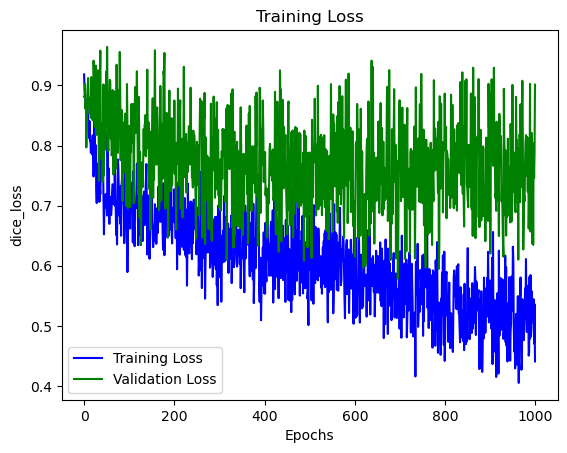

In [17]:
experiment.plot_loss()

In [18]:
import os
weights_dir = "/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/weights/"
name = '3-27-24_epochs1000'
weights_path = os.path.join(weights_dir, name + '.pt')
torch.save(experiment.model.state_dict(), weights_path)

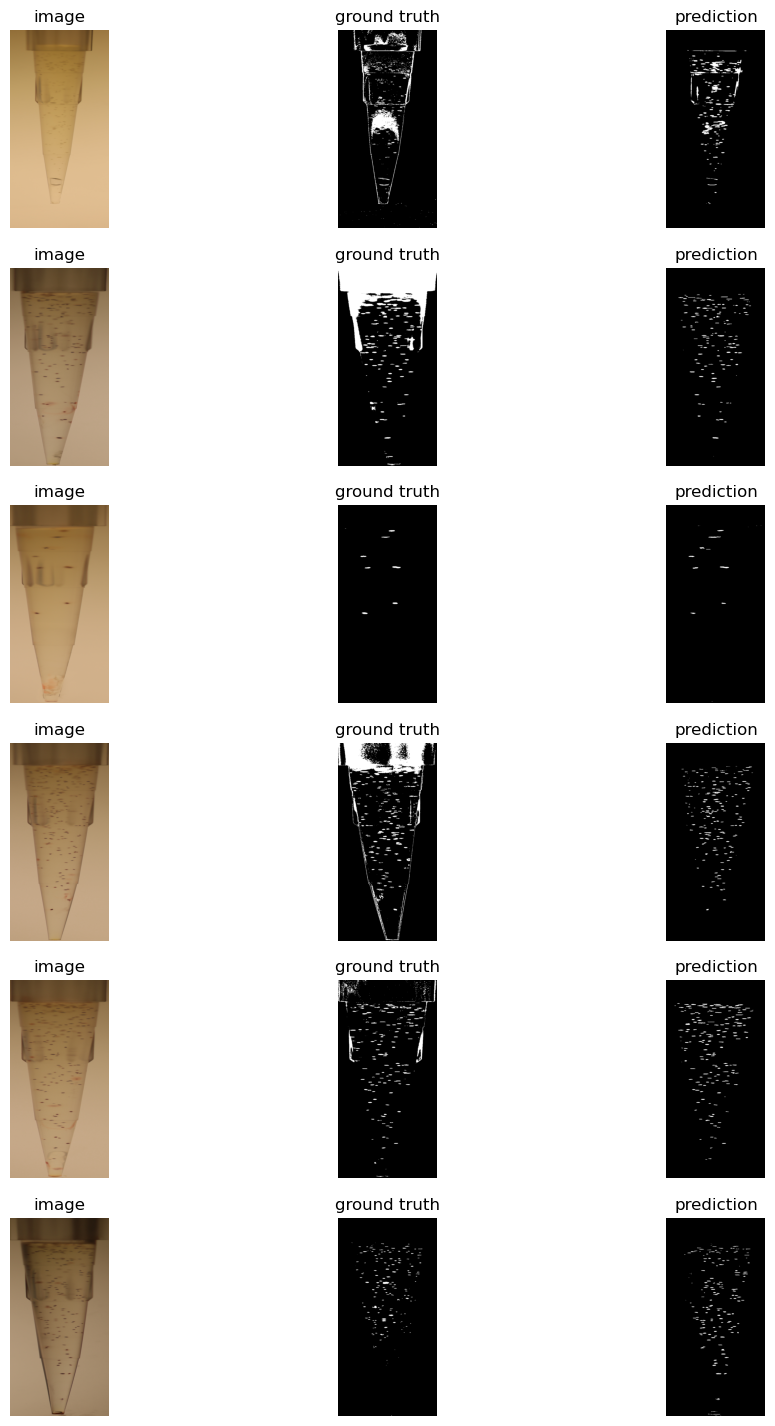

In [19]:
show_val()

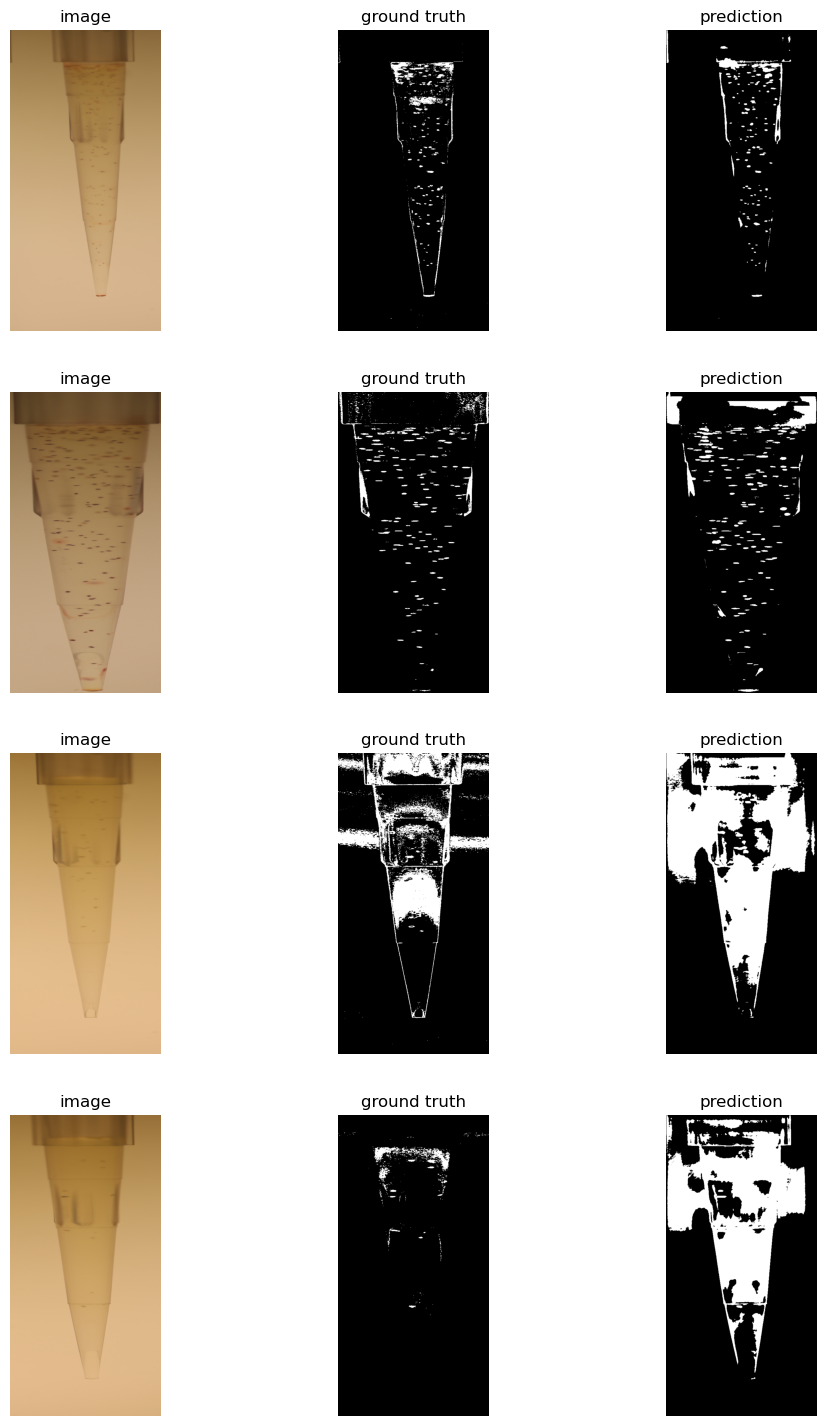

In [17]:
show_val()

In [ ]:
experiment.

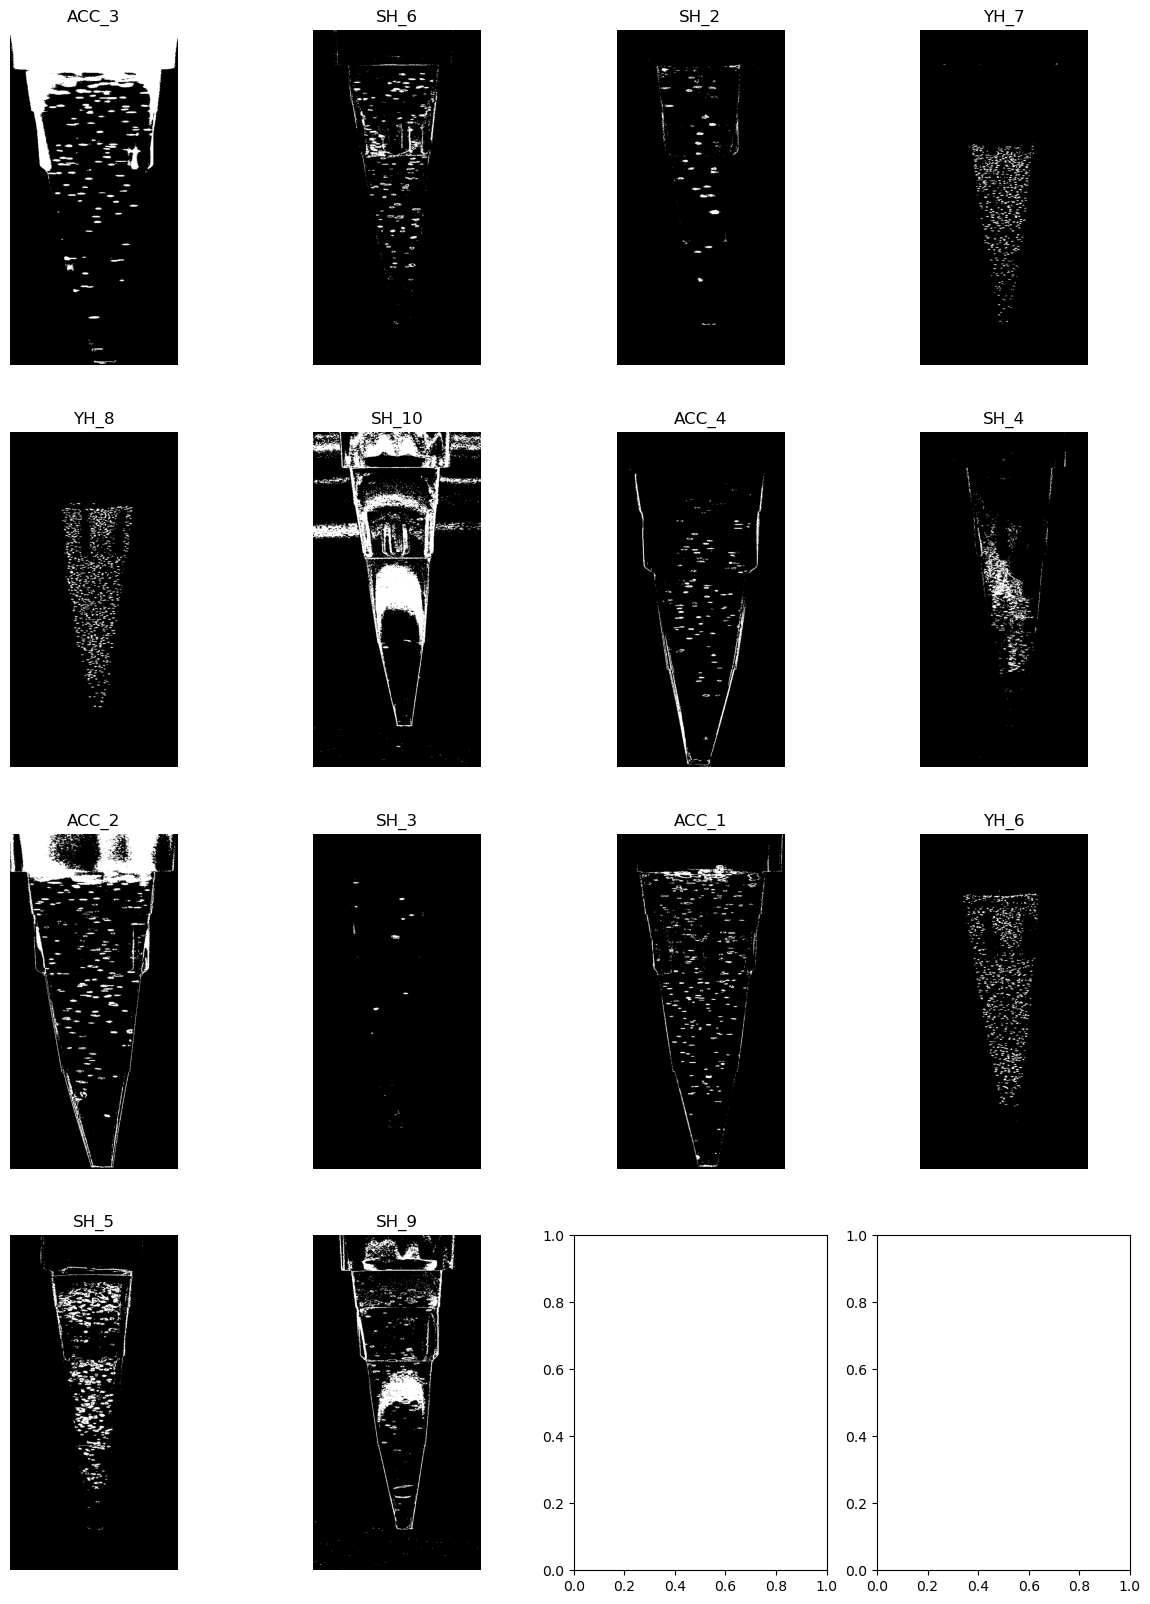

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(train_loader), 4, figsize=(15, 20))
for i, data in enumerate(train_loader):
    images, labels, file = data
    for j in range(4):
        if images.shape[0] == j:
            break
        img = labels[j]

        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].axis('off')
        ax[i, j].set_title(file[j])